# DCC GARCH 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Test R connection
import os
import rpy2.robjects as robjects

# Print R_HOME environment variable
print(f"R_HOME: {os.environ.get('R_HOME')}")

# Try R connection
print(robjects.r('R.version.string')[0])

R_HOME: C:\Program Files\R\R-4.4.2
R version 4.4.2 (2024-10-31 ucrt)


In [3]:
# Load data
df = pd.read_csv('transformed_data.csv', index_col=0, parse_dates=True)
# Convert index to datetime if not already 
df.index = pd.to_datetime(df.index)

# Calculate split point at 80%
split_point = int(len(df) * 0.8)

# Split data into train and test sets
df_train = df.iloc[:split_point]
df_test = df.iloc[split_point:]

print(f"Training set size: {len(df_train)} observations")
print(f"Test set size: {len(df_test)} observations")
print(f"Training period: {df_train.index[0]} to {df_train.index[-1]}")
print(f"Test period: {df_test.index[0]} to {df_test.index[-1]}")


Training set size: 3622 observations
Test set size: 906 observations
Training period: 2007-01-04 00:00:00 to 2021-05-24 00:00:00
Test period: 2021-05-25 00:00:00 to 2024-12-30 00:00:00


# DCC-GARCH Model

DCC-GARCH (Dynamic Conditional Correlation GARCH) models the time-varying correlations between multiple asset returns while accounting for individual volatility dynamics. The model captures both:
- Time-varying volatilities through univariate GARCH processes
- Dynamic correlations between assets that evolve over time

## Optimization Approaches

### 1. Joint Estimation
- All GARCH and DCC parameters are optimized simultaneously 
- Provides theoretically more efficient estimates
- However, computationally intensive and often faces convergence issues with high-dimensional data

### 2. Two-Step Estimation
- Step 1: Optimize univariate GARCH parameters separately for each series
- Step 2: Use standardized residuals to estimate DCC parameters while keeping GARCH parameters fixed

## Advantages of Two-Step Approach
- Computationally more efficient and tractable
- Better convergence properties, especially for high-dimensional systems
- Allows flexibility in specifying different GARCH models for each series
- Parameters from Step 1 remain consistent even if Step 2 is misspecified
- Enables estimation of large correlation matrices that would be infeasible with joint estimation


**Information Criterion Comparison**
- Akaike Information Criterion (AIC): Prioritizes model fit with a penalty for complexity, aiming to minimize information loss. It's often preferred in predictive modeling contexts.

- Bayesian Information Criterion (BIC): Applies a stricter penalty for complexity, favoring simpler models, especially as sample size increases. It's commonly used when the goal is to identify the true underlying model.

- Hannan-Quinn Information Criterion (HQIC): Balances between AIC and BIC, with a penalty term that grows slower than BIC but faster than AIC, offering a middle ground.

- Log-Likelihood: Measures model fit without penalizing complexity; higher values indicate better fit but can lead to overfitting if used alone.

For forecasting (minimizing prediction error), AIC might be preferable because it’s more geared toward predictive performance.

To uncover the “true” model structure (model parsimony) and avoid overfitting, then BIC is often recommended.


**The Custom Scoring Approach to Model Selection**
Rather than relying on a single metric, we implements a comprehensive scoring system that evaluates models across multiple dimensions. This is significant because volatility modeling is crucial for risk management and financial decision-making.

Why This Approach Is Advantageous:

1. Multi-dimensional Evaluation
Traditional approaches often select models based solely on information criteria like AIC or BIC. The custom scoring function instead evaluates models across six key dimensions:

Parameter significance (25% weight): Ensures the model components are statistically significant
Information criteria (20% weight): Balances model fit and complexity
Residual diagnostics (25% weight): Verifies that the model captures all patterns in the data
Stability (15% weight): Checks if parameters are consistent over time
Sign bias (10% weight): Evaluates how well the model handles asymmetric effects
Goodness-of-fit (5% weight): Assesses how well the theoretical distribution matches actual data

2. Better Risk Management
By identifying models that excel across multiple criteria, this approach produces more reliable volatility forecasts. This leads to:

More accurate Value-at-Risk (VaR) calculations
Better portfolio optimization
Improved hedging strategies
More reliable risk assessments

3. Systematic Exploration
The code systematically explores combinations of:

ARMA orders for the mean equation
GARCH orders for the variance equation
Different distributions (normal, Student-t, skewed Student-t)
Various GARCH types (standard, exponential, GJR)
This exhaustive search ensures no promising model specification is overlooked.

4. Hierarchical Optimization
The process first optimizes individual GARCH models for each series, then uses these as building blocks for the multivariate DCC-GARCH model. This hierarchical approach leads to better-fitting multivariate models.

5. Balancing Statistical Rigor with Practical Application
The weighted scoring approach balances pure statistical metrics with practical considerations like parameter stability and residual behavior, resulting in models that perform well not just in-sample but also for forecasting.



## Optimized Hyperparmeters for DCC GARCH

After optimizing the script "score.py" runs the custom scoring function to assign the score to each model paramters run.

In [18]:
garch_top_models = pd.read_csv('top_models_by_series.csv')
print(garch_top_models.head(9).to_string(index=False))

series garch_type  garch_p  garch_q  arma_p  arma_q distribution  param_significance  info_criteria  residual_diagnostics  stability  sign_bias  goodness_of_fit  total_score                                                                              key_strengths      AIC      BIC  loglikelihood
     1   gjrGARCH      2.0      1.0     1.0     0.0         sstd                0.25       0.102606              0.250000   0.132044   0.030795         0.038038     0.803483  Parameter significance (0.250), Residual diagnostics (0.250), Parameter stability (0.132)  2.41000  2.42710      -4354.433
     1     eGARCH      1.0      1.0     1.0     0.0         sstd                0.25       0.110862              0.250000   0.049543   0.100000         0.035443     0.795848 Parameter significance (0.250), Residual diagnostics (0.250), Information criteria (0.111)  2.15370  2.16740      -3892.426
     1     eGARCH      1.0      1.0     1.0     1.0         sstd                0.25       0.110835       

The results table shows the top three models selected for each financial series using our custom scoring approach. These parameters tell us about the underlying data characteristics:

Common Patterns Across All Series

Asymmetric Volatility Response: All top models use either gjrGARCH or eGARCH models, indicating that all three financial series exhibit leverage effects - negative shocks increase volatility more than positive shocks of the same magnitude. This is typical of financial assets where downward price movements create more market uncertainty than upward movements.

Non-Normal Return Distributions: All top models use either Student-t (std) or skewed Student-t (sstd) distributions, confirming that returns have heavier tails than normal distributions. This means extreme events occur more frequently than would be expected under normality assumptions.

Short-Term Memory in Returns: Most models incorporate AR(1) components (arma_p=1, arma_q=0), indicating that current returns are influenced by previous period returns.



In [19]:
# Read and display the best DCC model
best_dcc_model = pd.read_csv('best_dcc_model.csv')
print("Best DCC Model Parameters:")
print(best_dcc_model.to_string(index=False))

Best DCC Model Parameters:
 ModelID  DCC_A  DCC_B Distribution      AIC      BIC     HQIC  LogLikelihood  Error
       8      2      2          mvt 2.788953 2.853945 2.788736   -5012.794192    NaN


The output shows the optimized parameters for the Dynamic Conditional Correlation (DCC) GARCH model, which captures the time-varying relationships between multiple financial series. These parameters tell us about the underlying data:

Key Parameters
DCC_A = 2 (News Impact Parameter)

This parameter controls how quickly correlations between assets respond to new market information (shocks)
The value of 2 indicates a second-order effect, meaning:
Correlations don't just respond to the most recent market shock
There's a more complex reaction to market news that depends on multiple recent periods
The model captures how today's correlations are influenced by both yesterday's and the day-before-yesterday's market surprises

DCC_B = 2 (Memory Parameter)

This parameter determines how persistent correlations are over time
A second-order value (2) indicates:
Strong "memory" in correlation structure
Correlation changes happen gradually rather than abruptly
Past correlation states continue to influence current correlations for multiple periods
Market relationships have complex dynamics that don't reset quickly
Distribution = mvt (Multivariate Student's t)
This indicates the model uses a multivariate Student's t-distribution rather than a normal distribution
This choice is significant because it:
Accommodates fat tails (extreme events happen more frequently than normal distribution would predict)
Better captures joint extreme movements across multiple assets
More realistically models the tendency of financial markets to experience simultaneous extreme events
Model Fit Statistics

Complex Correlation Structure: The higher-order DCC model (2,2) suggests correlations between assets don't change simply or reactively - they evolve through a more complex process that depends on multiple periods of history.

Tail Risk Importance: The multivariate t-distribution indicates that extreme co-movements between assets are more likely than a normal distribution would suggest, highlighting the importance of managing tail risk.

Slow Adaptation: The parameters suggest correlation structures adapt gradually to new information, which has implications for how quickly diversification benefits might erode during changing market conditions.

## DCC GARCH implementation

Based on the optimized parameters we apply DCC GARCH and evaluate

In [21]:
from rpy2.robjects import pandas2ri

def dcc_garch(data):
    """
    Implement DCC-GARCH with optimized parameters
    
    Parameters:
    data (pandas.DataFrame): Input time series data
    
    Returns:
    tuple: (conditional correlations, conditional covariances, conditional volatilities, standardized residuals, fit summary)
    """
    import rpy2.robjects as robjects
    pandas2ri.activate()
    
    # Define R code with optimal parameters
    robjects.r('''
        library(rmgarch)
        
        dcc <- function(data) {
            # Convert data to matrix
            data_matrix <- as.matrix(data)
            
            # Define optimal GARCH specifications based on best performing models
            # For series 1: gjrGARCH(2,1) with ARMA(1,0) and sstd distribution
            spec1 <- ugarchspec(
                mean.model = list(armaOrder = c(1,0)),
                variance.model = list(model = "gjrGARCH", garchOrder = c(2,1)),
                distribution.model = "sstd"
            )
            
            # For series 2: gjrGARCH(1,1) with ARMA(1,0) and sstd distribution
            spec2 <- ugarchspec(
                mean.model = list(armaOrder = c(1,0)),
                variance.model = list(model = "gjrGARCH", garchOrder = c(1,1)),
                distribution.model = "sstd"
            )
            
            # For series 3: gjrGARCH(2,2) with ARMA(1,1) and sstd distribution
            spec3 <- ugarchspec(
                mean.model = list(armaOrder = c(1,1)),
                variance.model = list(model = "gjrGARCH", garchOrder = c(2,2)),
                distribution.model = "sstd"
            )
            
            # Create multivariate specification
            multi_spec <- multispec(c(spec1, spec2, spec3))
               
            # Fit individual UGARCH models for each series
            ugarch_fits <- list()
            for(i in 1:ncol(data_matrix)) {
                spec <- get(paste0("spec", i))
                ugarch_fits[[i]] <- ugarchfit(spec, data_matrix[,i], solver = "hybrid")
            }
            
            # Create DCC specification with optimal parameters (2,2) and mvt distribution
            # as identified in best_dcc_model
            dcc_spec <- dccspec(
                uspec = multi_spec,
                dccOrder = c(2,2),
                model = "DCC",
                distribution = "mvt"
               
            )
            
            # Fit the model
            fit <- dccfit(
                dcc_spec,
                data = data_matrix,
                fit = ugarch_fits,
               start.pars = c(0.03, 0.3),
                fit.control = list(eval.se = TRUE),
                solver = "solnp",
                solver.control = list(
                    tol = 1e-6,
                    trace = 0,
                    rho = 1,
                    max.iter = 5000
                )
            )
            
            # Extract results
            cors <- rcor(fit)
            covs <- rcov(fit)
            vols <- sigma(fit)
            resids <- fit@mfit$stdresid
            # Extract residuals from individual UGARCH models
            ugarch_resids <- lapply(ugarch_fits, function(x) residuals(x))
            # Convert to matrix for easier handling
            ugarch_resids_matrix <- do.call(cbind, ugarch_resids)
            # Extract DCC residuals
            dcc_resids <- residuals(fit)
            # Extract volatilities from individual GARCH models
            ugarch_vols <- lapply(ugarch_fits, function(x) sigma(x))
            ugarch_vols_matrix <- do.call(cbind, ugarch_vols)
            
            return(list(
                correlations = cors,
                covariance = covs,
                volatilities = vols,
                std_residuals = resids,
                fit = fit,
                ugarch_fits = ugarch_fits,
                dcc_resids = dcc_resids,
                ugarch_resids = ugarch_resids_matrix,
                ugarch_vols = ugarch_vols_matrix
            ))
        }
    ''')
    
    # Convert pandas DataFrame to R matrix
    r_data = pandas2ri.py2rpy(data)
    robjects.r.assign('data', r_data)
    
    # Call R function
    result = robjects.r('dcc(data)')
    
    # Convert results back to Python
    correlations = np.array(result[0])
    covariances = np.array(result[1])
    volatilities = np.array(result[2])
    std_residuals = np.array(result[3])
    fit_summary_dcc = str(result[4])
    fit_summary_garchs = str(result[5])
    dcc_resids = np.array(result[6])
    ugarch_resids = np.array(result[7])
    ugarch_vols = np.array(result[8])
    
    return correlations, covariances, volatilities, std_residuals, fit_summary_dcc, fit_summary_garchs, dcc_resids, ugarch_resids, ugarch_vols



In [22]:
correlations, covariances, volatilities, std_residuals, fit_summary_dcc, fit_summary_garchs, dcc_resids, ugarch_resids, ugarch_vols = dcc_garch(df_train)

In [23]:
import pickle

# Create a dictionary to store all results
all_results = {
    'correlations': correlations,
    'covariances': covariances,
    'volatilities': volatilities,
    'std_residuals': std_residuals,
    'ugarch_resids': ugarch_resids,
    'ugarch_vols': ugarch_vols,
    'dcc_resids': dcc_resids,
    'fit_summary_dcc': fit_summary_dcc,
    'fit_summary_garchs': fit_summary_garchs
}

# Create directory if it doesn't exist
results_dir = 'dcc_garch_results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Save individual numpy arrays
np.save(f'{results_dir}/correlations.npy', correlations)
np.save(f'{results_dir}/covariances.npy', covariances)
np.save(f'{results_dir}/volatilities.npy', volatilities)
np.save(f'{results_dir}/std_residuals.npy', std_residuals)
np.save(f'{results_dir}/ugarch_resids.npy', ugarch_resids)
np.save(f'{results_dir}/ugarch_vols.npy', ugarch_vols)
if dcc_resids is not None:
    np.save(f'{results_dir}/dcc_resids.npy', dcc_resids)

# Save text summaries
with open(f'{results_dir}/fit_summary_dcc.txt', 'w') as f:
    f.write(str(fit_summary_dcc))
with open(f'{results_dir}/fit_summary_garchs.txt', 'w') as f:
    f.write(str(fit_summary_garchs))

# Save everything in a single pickle file
with open(f'{results_dir}/all_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)

print(f"Results saved in {results_dir}/")

Results saved in dcc_garch_results/


In [24]:
import numpy as np
import os

# Load saved results

# Define the results directory
results_dir = 'dcc_garch_results'

# Load volatilities
volatilities = np.load(f'{results_dir}/volatilities.npy')

# Load DCC residuals
dcc_resids = np.load(f'{results_dir}/dcc_resids.npy')

# Load UGARCH residuals
ugarch_resids = np.load(f'{results_dir}/ugarch_resids.npy')

# Load UGARCH volatilities
ugarch_vols = np.load(f'{results_dir}/ugarch_vols.npy')

print("Loaded data shapes:")
print(f"Volatilities: {volatilities.shape}")
print(f"DCC residuals: {dcc_resids.shape}")
print(f"UGARCH residuals: {ugarch_resids.shape}")
print(f"UGARCH volatilities: {ugarch_vols.shape}")

Loaded data shapes:
Volatilities: (3622, 3)
DCC residuals: (3622, 3)
UGARCH residuals: (3622, 3)
UGARCH volatilities: (3622, 3)


In [16]:
print(str(fit_summary_dcc))


*---------------------------------*
*          DCC GARCH Fit          *
*---------------------------------*

Distribution         :  mvt
Model                :  DCC(2,2)
No. Parameters       :  38
[VAR GARCH DCC UncQ] : [0+30+5+3]
No. Series           :  3
No. Obs.             :  3622
Log-Likelihood       :  -5012.825
Av.Log-Likelihood    :  -1.38 

Optimal Parameters
-----------------------------------
                                  Estimate  Std. Error   t value Pr(>|t|)
[S&P500].mu                       0.004161    0.009211  0.451704 0.651482
[S&P500].ar1                     -0.079836    0.016744 -4.768125 0.000002
[S&P500].omega                    0.017147    0.003445  4.977492 0.000001
[S&P500].alpha1                   0.000012    0.034272  0.000357 0.999715
[S&P500].alpha2                   0.017373    0.031486  0.551791 0.581091
[S&P500].beta1                    0.836305    0.020637 40.524425 0.000000
[S&P500].gamma1                   0.171942    0.053013  3.243423 0.001181


In [6]:
print(str(fit_summary_dcc))


*---------------------------------*
*          DCC GARCH Fit          *
*---------------------------------*

Distribution         :  mvt
Model                :  DCC(2,2)
No. Parameters       :  38
[VAR GARCH DCC UncQ] : [0+30+5+3]
No. Series           :  3
No. Obs.             :  3622
Log-Likelihood       :  -5008.35
Av.Log-Likelihood    :  -1.38 

Optimal Parameters
-----------------------------------
                                  Estimate  Std. Error     t value Pr(>|t|)
[S&P500].mu                       0.004161    0.009216  4.5145e-01 0.651668
[S&P500].ar1                     -0.079832    0.016724 -4.7735e+00 0.000002
[S&P500].omega                    0.017147    0.003450  4.9695e+00 0.000001
[S&P500].alpha1                   0.000000    0.034257  2.0000e-06 0.999998
[S&P500].alpha2                   0.017382    0.031480  5.5216e-01 0.580842
[S&P500].beta1                    0.836302    0.020695  4.0411e+01 0.000000
[S&P500].gamma1                   0.171945    0.053013  3.243

In [7]:
print(str(fit_summary_garchs))

[[1]]

*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: gjrGARCH(2,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: sstd 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.004160    0.009095  0.457364 0.647409
ar1    -0.079834    0.016705 -4.779136 0.000002
omega   0.017147    0.002908  5.897360 0.000000
alpha1  0.000000    0.028317  0.000003 0.999997
alpha2  0.017385    0.027900  0.623104 0.533217
beta1   0.836303    0.017422 48.003801 0.000000
gamma1  0.171948    0.047227  3.640874 0.000272
gamma2  0.091933    0.049516  1.856621 0.063365
skew    0.836860    0.019627 42.638918 0.000000
shape   5.696332    0.561806 10.139327 0.000000

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.004160    0.008822  0.471526 0.637265
ar1    -0.079834    0.015020 -5.31

### DCC GARCH results summary

Understanding the DCC-GARCH Model Results:

S&P500 (Stock Market)

Asymmetric response to news: The positive gamma1 (0.17) shows that negative market shocks increase future volatility much more than positive news - confirming the "leverage effect" in equity markets
Persistent volatility: High beta1 (0.84) indicates that once volatility increases, it tends to stay elevated for extended periods

Left-skewed returns: The skew parameter (0.84) below 1 confirms stock returns have more frequent negative outliers than positive ones

Fat tails: Shape parameter of 5.7 indicates substantially more extreme events than a normal distribution would predict

Treasury Yield Spread

Momentum in yield changes: Positive AR1 parameter (0.09) shows slight persistence in spread movements

Different news impact: The negative gamma1 (-0.06) means that, unlike stocks, positive surprises in yield spreads can create more uncertainty than negative ones

High volatility persistence: Beta1 (0.87) shows that volatility in bond spreads is even more persistent than in stocks

VIX (Volatility Index)

Strong mean reversion: Very high AR1 (0.99) combined with negative MA1 (-0.08) shows VIX strongly gravitates back to typical levels after spikes

Complex volatility pattern: Needs more parameters (GARCH(2,2)) to capture its behavior

Negative asymmetry coefficients: Unlike stocks, VIX responds differently to shocks (negative gammas)

Highly right-skewed: Skew of 1.35 indicates more frequent positive spikes in market volatility

Understanding the Relationships Between Markets

The DCC parameters tell us how these three markets interact:

dcca1 & dcca2 (both around 0.03): These measure how quickly correlations change when markets experience shocks - the relatively small values suggest correlations don't overreact to daily news
dccb1 & dccb2 (0.33 and 0.55): These show the persistence in correlation patterns - the high values indicate that when relationships between these markets change, they tend to maintain their new pattern for extended periods
mshape (6.06): This confirms that these markets experience joint extreme movements more often than normal distributions would predict

Why Parameters Differ Between Individual and Joint Analysis

We may notice slight differences in the parameter values between the individual analyses and the joint DCC model. This happens because:

Shared information effect: When analyzing markets together, information from one market helps better estimate another market's behavior

Correlation dynamics: The joint model accounts for how these markets move together, which slightly adjusts individual behavior estimates

System-wide view: The DCC approach considers the entire financial system rather than isolated pieces
These differences are actually quite small in your results (often in the fourth decimal place), indicating that the individual characteristics of each market remain consistent even when analyzed together - a sign of a well-specified model.

The joint analysis provides a more complete picture of market behavior by capturing not just how each market behaves individually, but how they influence and react to each other over time.




## Diagnostic Tests on GARCH Model Residuals

Three key diagnostic tests are performed to assess the adequacy of the DCC-GARCH model:

### 1. Ljung-Box Test 
- Tests for autocorrelation in the residuals
- Null hypothesis: No autocorrelation exists
- Significant p-values (< 0.05) indicate remaining autocorrelation and potential model misspecification

### 2. ARCH-LM Test
- Tests for remaining ARCH effects in the residuals
- Null hypothesis: No ARCH effects present
- Significant p-values suggest inadequate volatility modeling

### 3. Jarque-Bera Test
- Tests for normality of the residuals
- Null hypothesis: Residuals are normally distributed  
- Significant p-values indicate non-normal distribution
- Non-normality is common in financial returns and not necessarily problematic if accounted for in model specification

The combined results of these tests help evaluate whether the DCC-GARCH model adequately captures the dynamics in the data or if refinements are needed.

In [67]:

from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera

def perform_diagnostic_tests(residuals, asset_names):
    """
    Perform diagnostic tests on GARCH model residuals.
    
    Parameters:
    residuals: numpy array of shape (n_obs, n_assets) containing standardized residuals
    asset_names: list of asset names corresponding to residual series
    
    Returns:
    pd.DataFrame: Results of diagnostic tests including Ljung-Box, ARCH-LM and Jarque-Bera tests
    """
    import scipy.stats as stats
    
    # Initialize results dictionary
    results = {
        'Asset': [],
        'Ljung-Box (1 lag) p-value': [],
        'Ljung-Box (5 lags) p-value': [],
        'Ljung-Box (10 lags) p-value': [],
        'Squared Residuals LB (1) p-value': [],
        'Squared Residuals LB (5) p-value': [],
        'Squared Residuals LB (10) p-value': [],
        'ARCH-LM (5) p-value': [],
        'ARCH-LM (10) p-value': [],
        'Jarque-Bera p-value': [],
        'Skewness': [],
        'Kurtosis': []
    }
    
    # Loop through each asset's residuals
    for i, asset in enumerate(asset_names):
        series = residuals[:, i]
        squared_series = series**2
        
        # Add asset name
        results['Asset'].append(asset)
        
        # Ljung-Box test for autocorrelation in residuals
        lb_1 = acorr_ljungbox(series, lags=[1], return_df=True)
        lb_5 = acorr_ljungbox(series, lags=[5], return_df=True)
        lb_10 = acorr_ljungbox(series, lags=[10], return_df=True)
        results['Ljung-Box (1 lag) p-value'].append(lb_1['lb_pvalue'].iloc[0])
        results['Ljung-Box (5 lags) p-value'].append(lb_5['lb_pvalue'].iloc[0])
        results['Ljung-Box (10 lags) p-value'].append(lb_10['lb_pvalue'].iloc[0])
        
        # Ljung-Box test for squared residuals (ARCH effects)
        sq_lb_1 = acorr_ljungbox(squared_series, lags=[1], return_df=True)
        sq_lb_5 = acorr_ljungbox(squared_series, lags=[5], return_df=True)
        sq_lb_10 = acorr_ljungbox(squared_series, lags=[10], return_df=True)
        results['Squared Residuals LB (1) p-value'].append(sq_lb_1['lb_pvalue'].iloc[0])
        results['Squared Residuals LB (5) p-value'].append(sq_lb_5['lb_pvalue'].iloc[0])
        results['Squared Residuals LB (10) p-value'].append(sq_lb_10['lb_pvalue'].iloc[0])
        
        # ARCH-LM test for remaining ARCH effects
        arch_5 = het_arch(series, nlags=5)
        arch_10 = het_arch(series, nlags=10)
        results['ARCH-LM (5) p-value'].append(arch_5[1])
        results['ARCH-LM (10) p-value'].append(arch_10[1])
        
        # Jarque-Bera test for normality
        jb = jarque_bera(series)
        results['Jarque-Bera p-value'].append(jb[1])
        
        # Calculate skewness and kurtosis
        results['Skewness'].append(stats.skew(series))
        results['Kurtosis'].append(stats.kurtosis(series, fisher=False))  # Using 'fisher=False' to get raw kurtosis, not excess
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    
    # Format p-values for better readability
    p_value_columns = [col for col in results_df.columns if 'p-value' in col]
    for col in p_value_columns:
        results_df[col] = results_df[col].apply(lambda x: f"{x:.4f}" + ('*' if x < 0.05 else ''))
    
    return results_df

perform_diagnostic_tests(std_residuals, df_train.columns)


,Asset,Ljung-Box (1 lag) p-value,Ljung-Box (5 lags) p-value,Ljung-Box (10 lags) p-value,Squared Residuals LB (1) p-value,Squared Residuals LB (5) p-value,Squared Residuals LB (10) p-value,ARCH-LM (5) p-value,ARCH-LM (10) p-value,Jarque-Bera p-value,Skewness,Kurtosis
0,S&P500,0.1151,0.5025,0.3264,0.0376*,0.0619,0.2872,0.0549,0.2702,0.0000*,-0.573549,6.090799
1,Treasury_30y_10y_Spread,0.7689,0.2335,0.4464,0.0620,0.5640,0.7284,0.5701,0.7505,0.0000*,0.091404,6.982223
2,VIX,0.6643,0.0054*,0.0001*,0.4510,0.8658,0.7865,0.8502,0.5629,0.0000*,0.643596,7.430794


These diagnostic tests analyze whether our DCC-GARCH model has effectively captured all patterns in the data. If our model is well-specified, the "standardized residuals" (what's left unexplained by the model) should behave like random noise with no patterns.

Interpreting the Results:

Serial Correlation Tests (Ljung-Box)
These tests check if today's residuals are influenced by previous days' residuals

S&P500 & Treasury Spread: All p-values are above 0.05, meaning there's no significant pattern left in the residuals. This is good news - our model has captured the time-series behavior well.

VIX: While the 1-day test looks good (p=0.6643), the 5-day and 10-day tests show significant patterns (marked with *). This suggests our model hasn't fully captured some weekly or bi-weekly cycles in VIX movements.

Volatility Clustering Tests (Squared Residuals LB & ARCH-LM)
These tests check if periods of high volatility tend to cluster together:

S&P500: One marginally significant result at 1-lag (p=0.0376*) suggests there might still be some very short-term volatility patterns not fully captured.

Treasury Spread & VIX: All tests have p-values > 0.05, indicating that the volatility clustering has been well captured by our DCC-GARCH model.

Distribution Tests (Jarque-Bera, Skewness, Kurtosis)
These tests check the shape of the residuals' distribution:

All three assets: Highly significant Jarque-Bera tests (p=0.0000*) indicate the residuals aren't normally distributed. Thats why skew t distribution was found in optimized hyperparameters.

S&P500: Negative skewness (-0.57) shows more extreme negative surprises, and high kurtosis (6.09) shows more frequent extreme events than a normal distribution.

Treasury Spread: Near-zero skewness (0.09) but high kurtosis (6.98) indicates symmetric but fat-tailed distribution.

VIX: Positive skewness (0.64) and highest kurtosis (7.43) reflects VIX's tendency for sudden upward spikes.


Overall Good Fit: The model has successfully captured most patterns in volatility and correlations across these markets.

Remaining Challenge with VIX: There's some weekly or bi-weekly pattern in VIX that our model doesn't fully explain.

Non-Normal Market Behavior: The significant Jarque-Bera tests confirm that financial markets don't behave according to "normal" statistical distributions - extreme events happen much more frequently than a bell curve would predict.


This diagnostic analysis gives us confidence that our DCC-GARCH model is appropriately specified, though some improvement might be possible.

## Visual Analysis of GARCH Model Residuals

### 1. QQ Plot Analysis
- Compares residual quantiles against theoretical normal distribution
- Deviations from diagonal line indicate non-normality
- Helps identify heavy tails and asymmetry in residual distribution

### 2. Residual Time Series Plot  
- Shows residuals over time
- Helps detect:
    - Volatility clusters
    - Outliers
    - Changes in variance
    - Any remaining patterns in residuals

### 3. Autocorrelation Function (ACF) Plot
- Displays autocorrelations at different lags
- Significant spikes indicate:
    - Remaining serial correlation
    - Model inadequacy in capturing time dependencies
    - Need for additional ARCH/GARCH terms

### 4. Squared Residuals ACF Plot
- Shows autocorrelation in squared residuals
- Helps identify:
    - Remaining ARCH effects
    - Adequacy of volatility modeling
    - Need for higher order GARCH terms

### 5. Histogram with Normal Overlay
- Visualizes residual distribution vs normal curve
- Reveals:
    - Non-normality
    - Skewness
    - Excess kurtosis
    - Fat tails

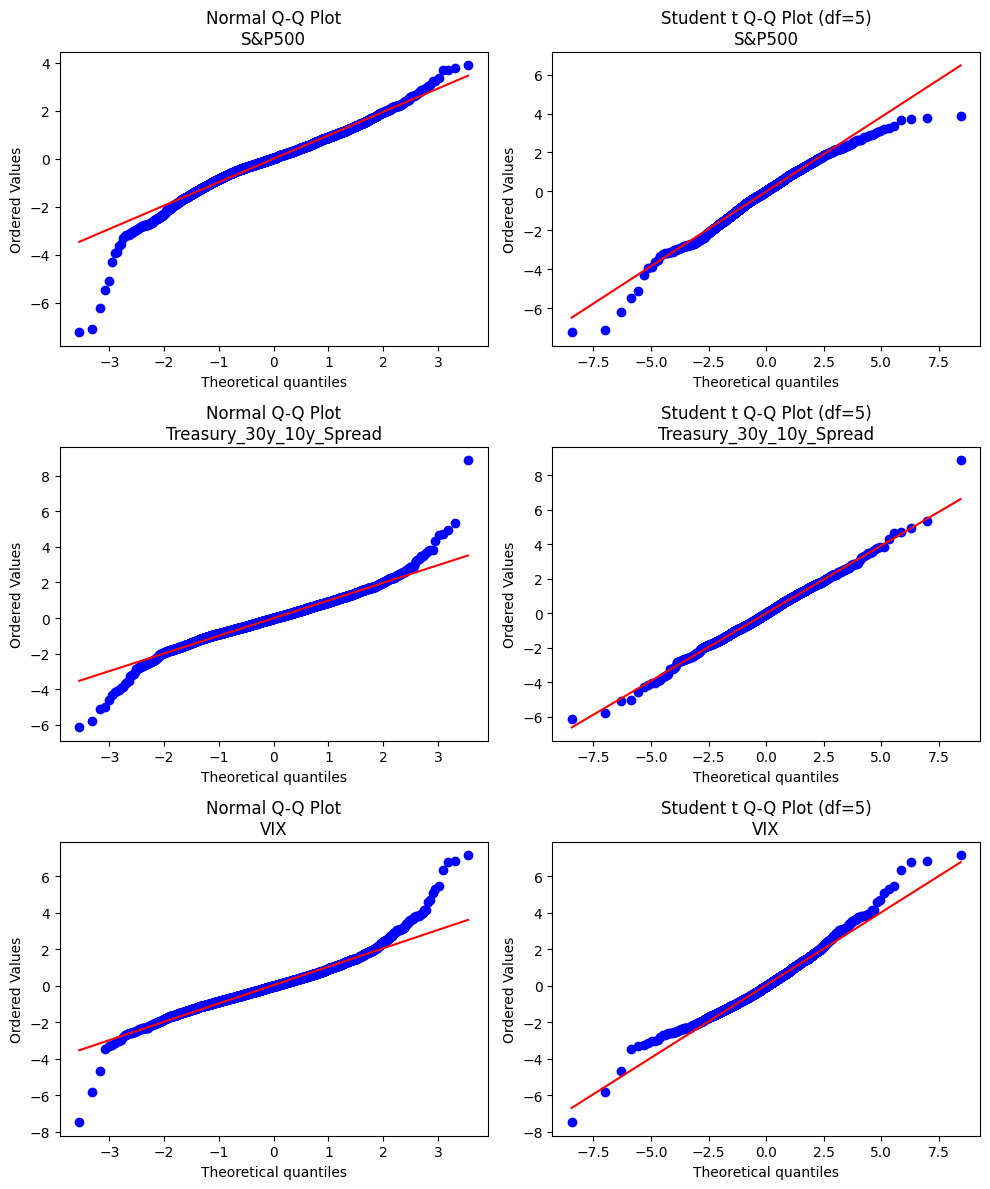

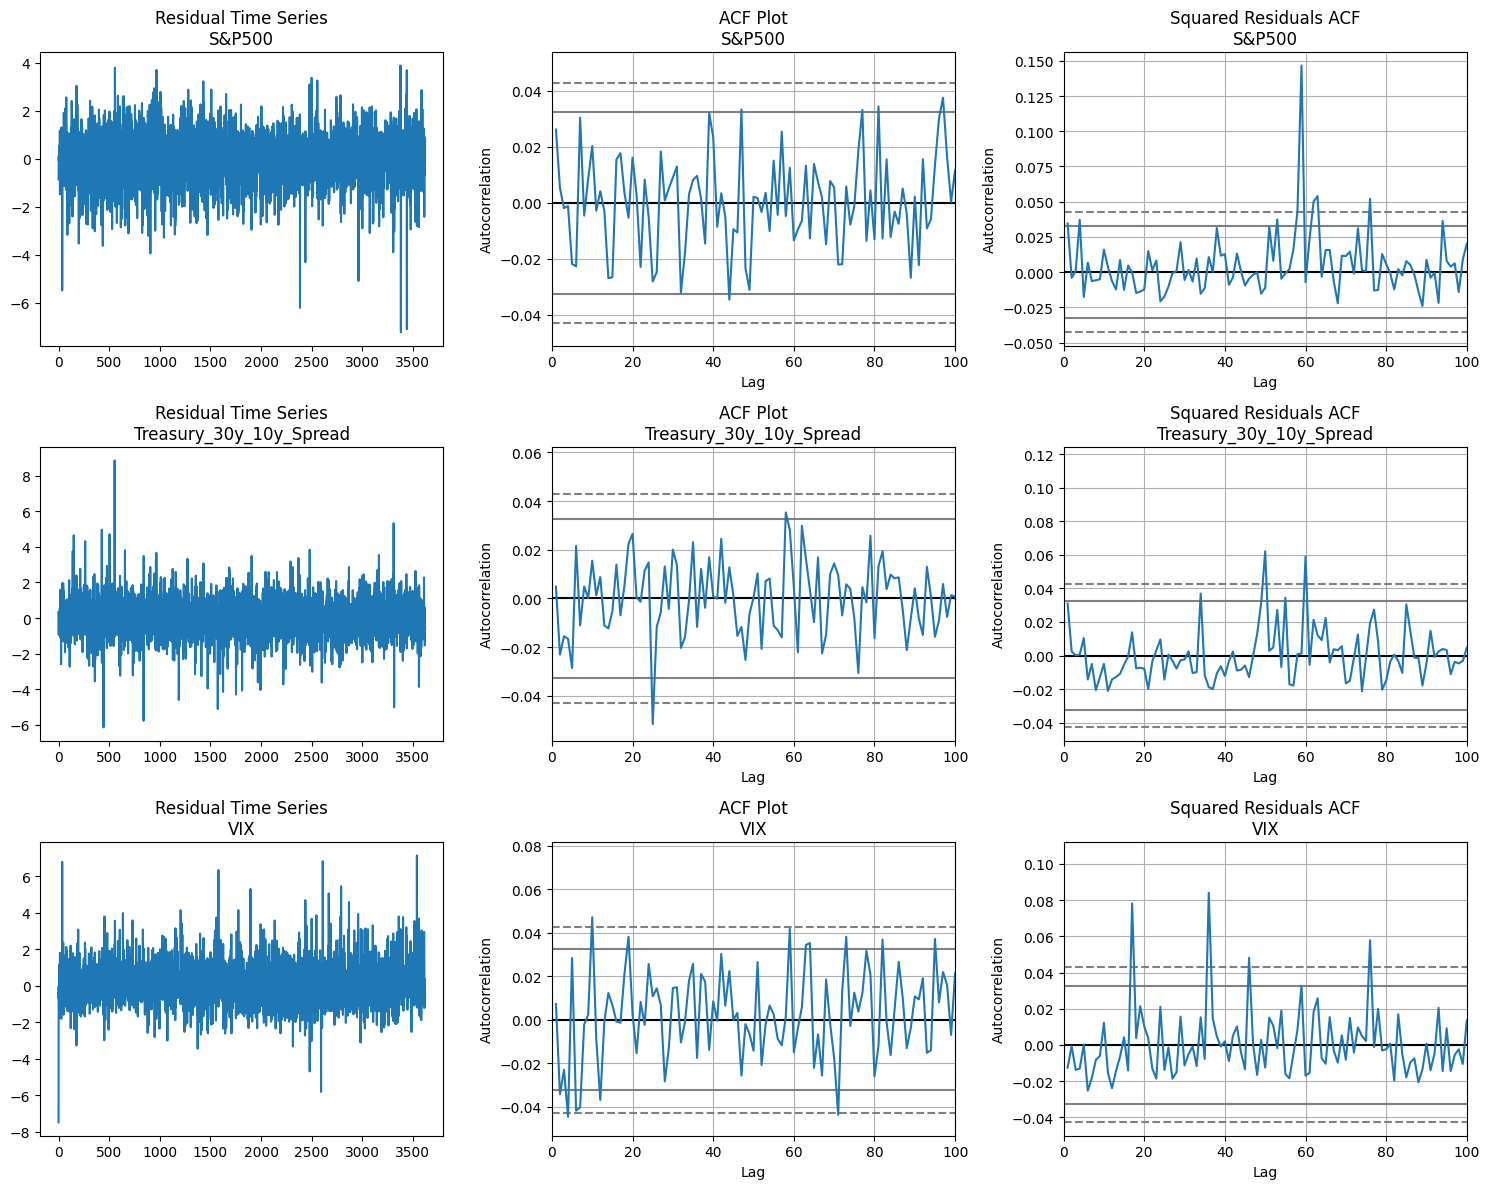

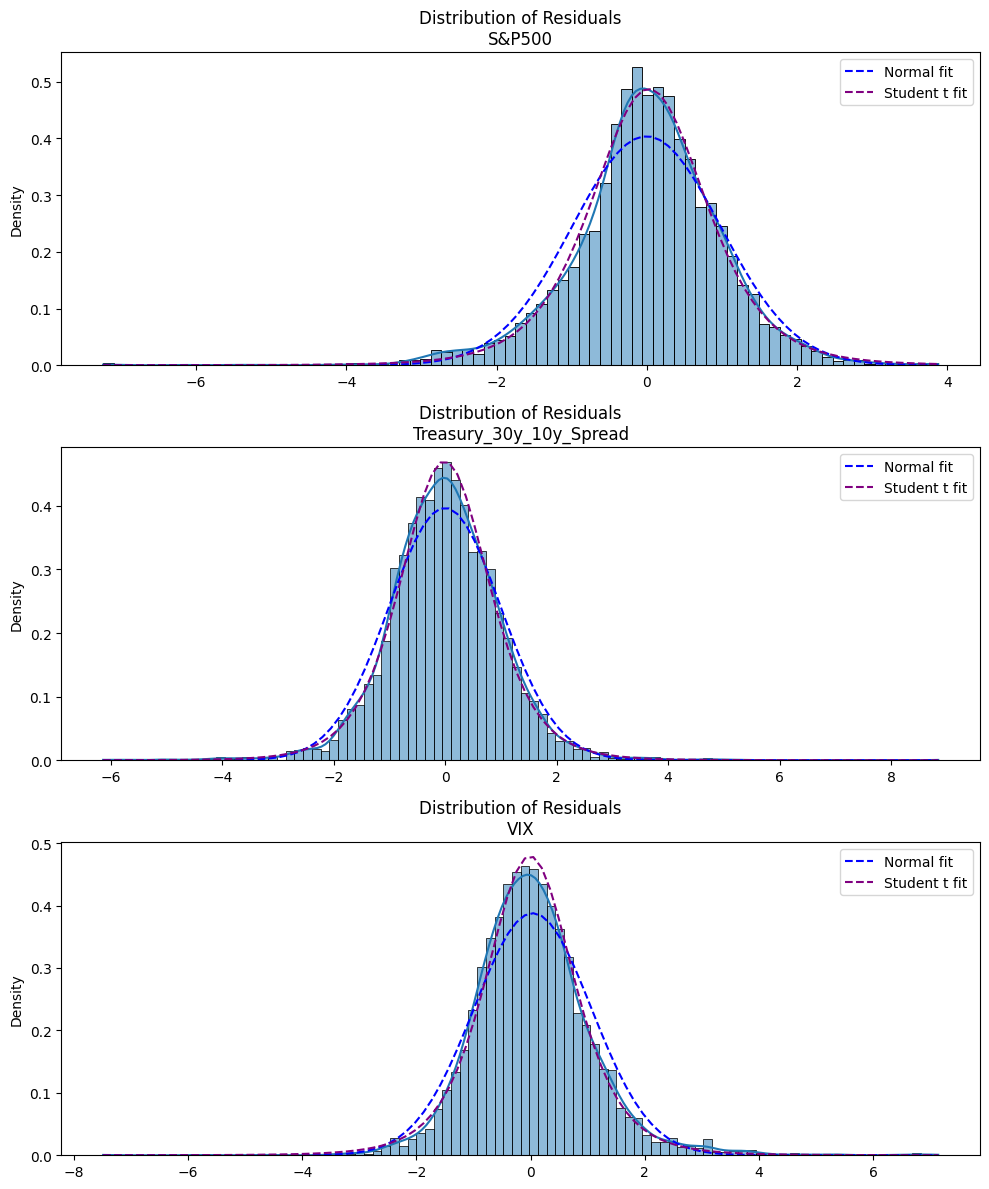

In [80]:
def visualize_dcc_garch_residuals(residuals, asset_names):
    """
    Create visualizations for GARCH model residuals with separate figures
    for QQ plots, time series analysis, and distribution analysis
    
    Parameters:
    residuals: numpy array of shape (n_obs, n_assets) containing model residuals
    asset_names: list of asset names corresponding to residual series
    """
    import scipy.stats as stats
    n_assets = len(asset_names)
    
    # Figure 1: QQ Plots
    fig_qq = plt.figure(figsize=(10, 4*n_assets))
    for i in range(n_assets):
        series = residuals[:, i]
        
        # Normal QQ Plot
        ax1 = plt.subplot(n_assets, 2, 2*i + 1)
        stats.probplot(series, dist="norm", plot=ax1)
        ax1.set_title(f'Normal Q-Q Plot\n{asset_names[i]}')
        
        # Student t QQ Plot
        ax2 = plt.subplot(n_assets, 2, 2*i + 2)
        stats.probplot(series, dist=stats.t, sparams=(5,), plot=ax2)
        ax2.set_title(f'Student t Q-Q Plot (df=5)\n{asset_names[i]}')
    
    plt.tight_layout()
    plt.show()
    
    # Figure 2: Time Series Analysis
    fig_ts = plt.figure(figsize=(15, 4*n_assets))
    for i in range(n_assets):
        series = residuals[:, i]
        
        # Time Series Plot
        ax1 = plt.subplot(n_assets, 3, 3*i + 1)
        ax1.plot(series)
        ax1.set_title(f'Residual Time Series\n{asset_names[i]}')
        
        # ACF Plot
        ax2 = plt.subplot(n_assets, 3, 3*i + 2)
        pd.plotting.autocorrelation_plot(pd.Series(series), ax=ax2)
        ax2.set_title(f'ACF Plot\n{asset_names[i]}')
        ax2.set_xlim([0, 100])
        
        # Squared Residuals ACF Plot
        ax3 = plt.subplot(n_assets, 3, 3*i + 3)
        pd.plotting.autocorrelation_plot(pd.Series(series**2), ax=ax3)
        ax3.set_title(f'Squared Residuals ACF\n{asset_names[i]}')
        ax3.set_xlim([0, 100])
    
    plt.tight_layout()
    plt.show()
    
    # Figure 3: Distribution Analysis
    fig_dist = plt.figure(figsize=(10, 4*n_assets))
    for i in range(n_assets):
        series = residuals[:, i]
        
        ax = plt.subplot(n_assets, 1, i + 1)
        sns.histplot(series, stat='density', kde=True, ax=ax)
        ax.set_title(f'Distribution of Residuals\n{asset_names[i]}')
        
        # Fit and plot normal distribution
        mean = series.mean()
        std = series.std()
        x = np.linspace(series.min(), series.max(), 100)
        normal_pdf = stats.norm.pdf(x, mean, std)
        ax.plot(x, normal_pdf, color='blue', linestyle='--', label='Normal fit')
        
        # Fit and plot student t distribution
        df_t, loc_t, scale_t = stats.t.fit(series)
        t_pdf = stats.t.pdf(x, df_t, loc_t, scale_t)
        ax.plot(x, t_pdf, color='purple', linestyle='--', label='Student t fit')
        
        
        ax.legend()
    
    plt.tight_layout()
    plt.show()

visualize_dcc_garch_residuals(std_residuals, df_train.columns)

As from the Q-Q plot, the tail behavior isn't being captured by the normal distrbution and the plot shows deviations on edges while student t distribution capturing most of the behavior for all series. Only few point don't really coincide with the line. As from optimization, we have fitted with skew student t and our choice is being confirmed by the Q-Q plot.

Standardized Residual Time Series

Residuals oscillating around zero, with no obvious trends or patterns.
No large clustering or persistent volatility in the standardized residuals themselves (since GARCH is meant to capture volatility clustering).

Each of the three standardized residual series (S&P 500, Treasury Spread, VIX) centers around zero without systematic drifts.
Visually, there do not appear to be long stretches of consistently positive or negative values, suggesting the mean dynamics are well-modeled.
Any large outliers are now moderated once the GARCH structure has been accounted for, though occasional spikes can still occur.

The lack of any visible trend or pattern indicates the conditional mean has been successfully removed.
While minor spikes can happen, what matters is that they are isolated and do not show prolonged clustering that would suggest unmodeled volatility.

ACF of Standardized Residuals

No significant autocorrelation at any lag—i.e., all ACF values should lie within the approximate ±2 standard-error bounds (often drawn as dashed lines in the ACF plots).

Most lags stay well within the confidence bands for each of the three series.
A small spike at a particular lag can occur by chance, especially in large samples. Occasional single-lag exceedances do not necessarily indicate misspecification, provided they do not form a systematic pattern.

The near-zero autocorrelation across lags indicates the model has captured the time-dependence in returns (or changes) properly.
If there is a slight spike at, say, lag 1 or 2, one could test its significance formally (e.g., using Ljung-Box tests). Which we did and find that accept for VIX, the test rejected the null hypothesis of correlation among residuals.

ACF of Squared Standardized Residuals

No significant autocorrelation in the squared residuals—this suggests that the GARCH structure has effectively captured conditional heteroskedasticity (volatility clustering). If there was leftover GARCH-like behavior, we would see spikes in the ACF of the squared residuals.

For S&P 500, the squared residuals appear uncorrelated across most lags, though there might be a small spike at a very low lag.
The Treasury spread and VIX also show minor spikes here or there, but generally remain within or near the confidence bounds.
None of the series exhibits a pronounced pattern of significant spikes across multiple lags.

The absence of large and systematic autocorrelation in squared residuals indicates that the GARCH component is doing its job.
Small individual spikes can appear by chance; what matters is that they are not persistent or repeated at multiple lags.

Overall Model Adequacy

Mean Equation: Residual time series oscillate around zero, implying the mean (or ARMA) portion is properly captured.
Volatility Modeling: Minimal or no clustering in squared residuals’ ACF suggests the GARCH component is well-specified.

No Systematic Leftover Correlation: ACF of residuals is close to zero across lags, so there is no major linear correlation unmodeled.
Possible Minor Caveats

The standardized residual plots suggest that the DCC-GARCH model has adequately removed both the linear correlation (no strong autocorrelation in residuals) and the conditional heteroskedasticity (no strong autocorrelation in squared residuals) for each of the three series (S&P 500, Treasury spread, VIX).
Minor spikes at isolated lags do not necessarily imply model failure; formal tests (Ljung-Box or ARCH tests) have confirmed that, overall, the residuals behave like white noise and the model is well-specified.
Hence, these diagnostics provide reasonable evidence that your DCC-GARCH specification is capturing both the dynamic correlations and the time-varying volatility structure in the data.

## Conditional Volatility

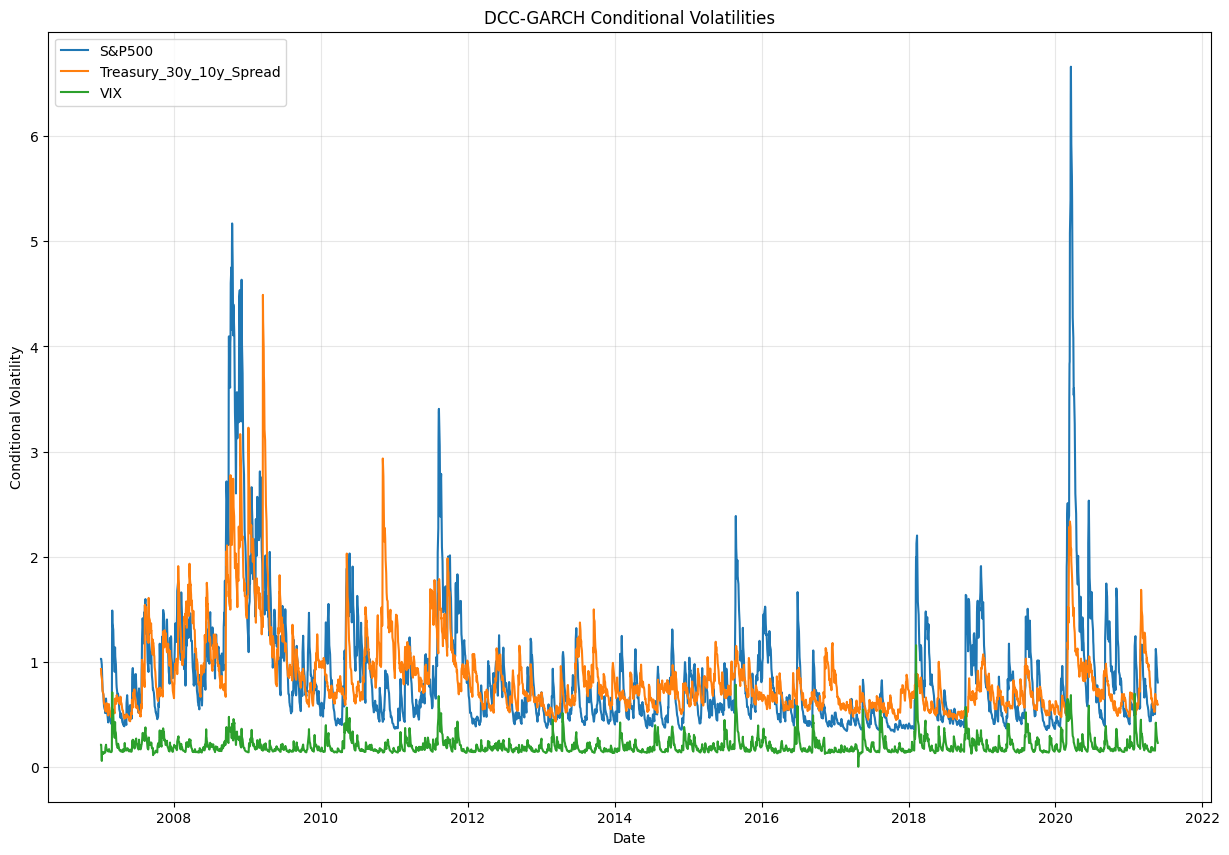

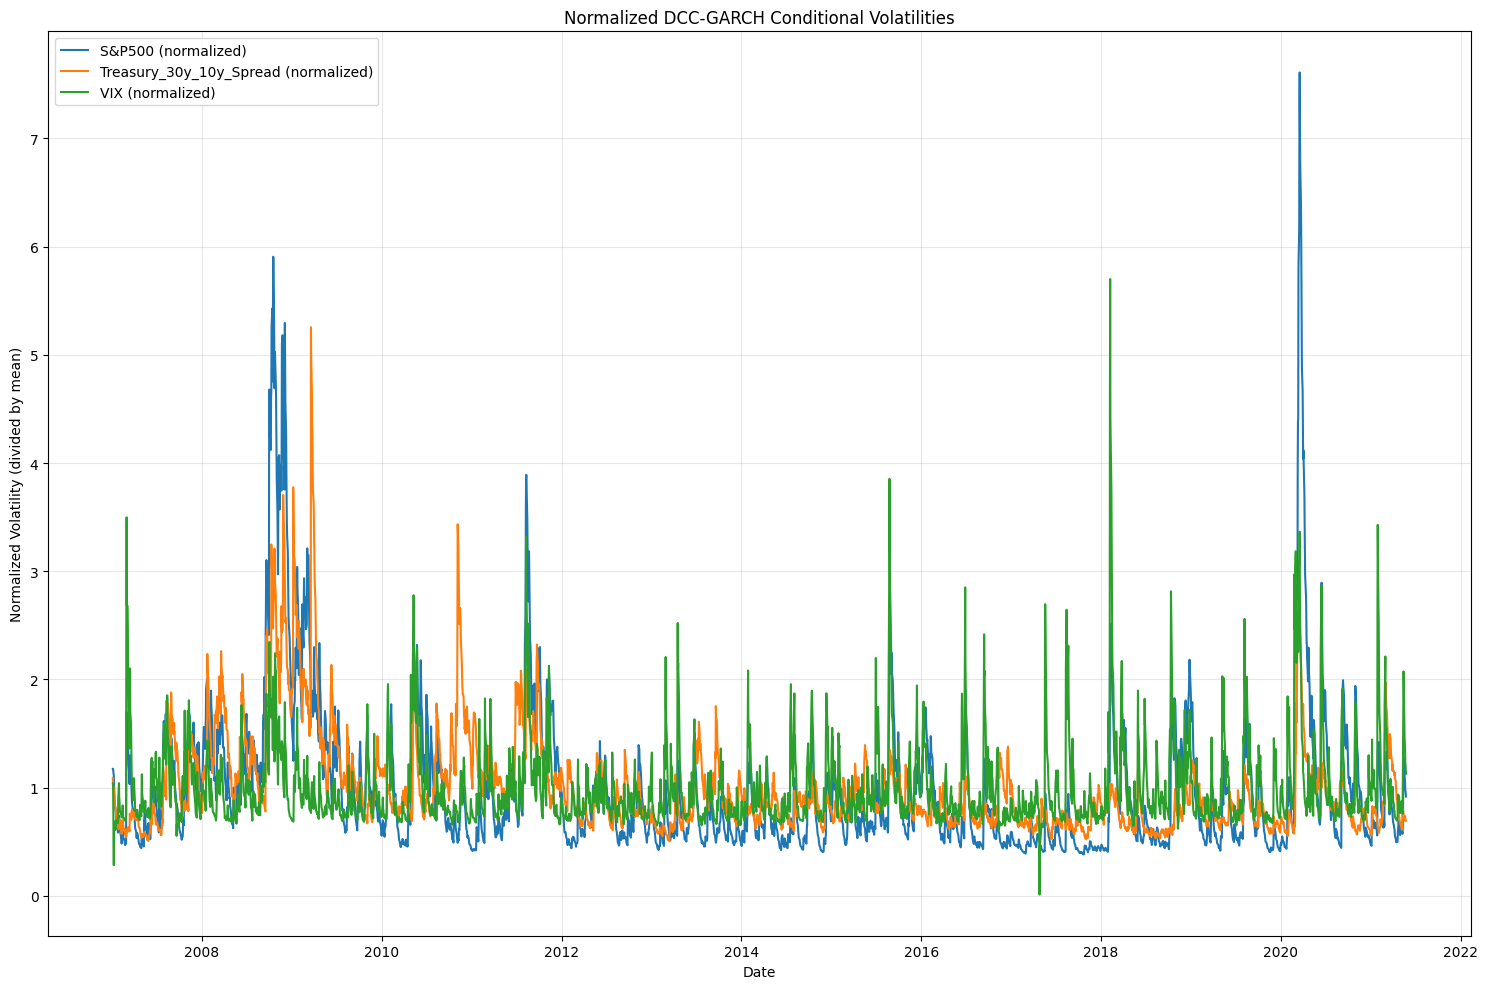

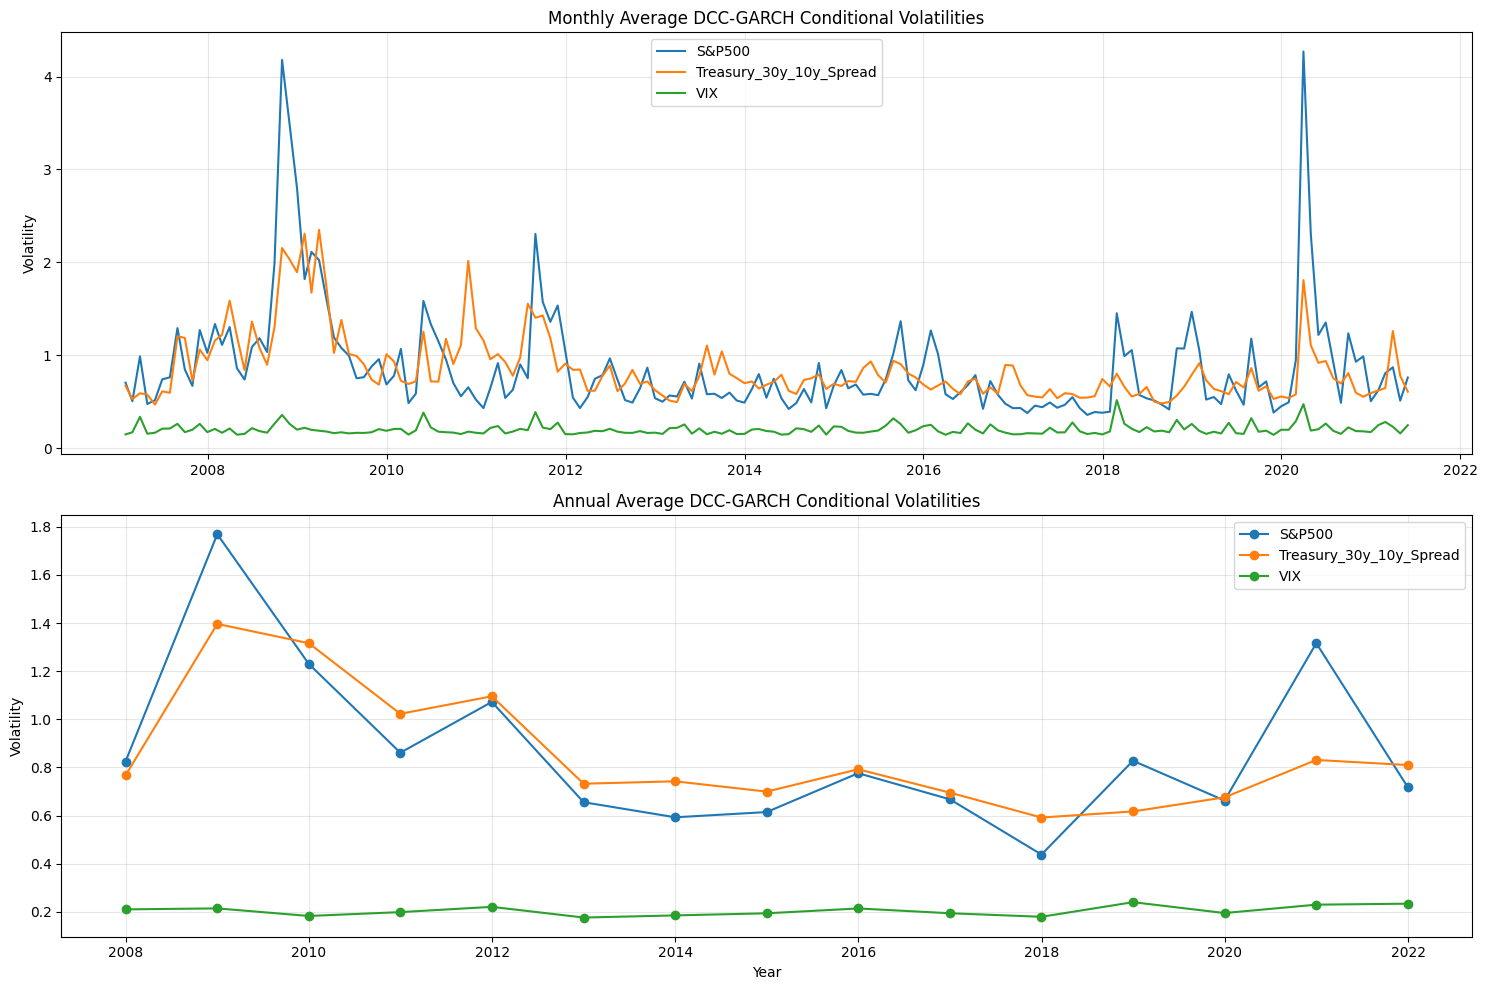

In [88]:
def plot_dcc_garch_volatilities(volatilities, dates, asset_names):
    """
    Plot conditional volatilities from DCC-GARCH model for all series
    
    Parameters:
    volatilities: numpy array of shape (n_obs, n_assets) containing volatilities
    dates: pandas DatetimeIndex with dates corresponding to observations
    asset_names: list of asset names corresponding to columns
    """
    # Create DataFrame for volatilities with dates as index
    vol_df = pd.DataFrame(volatilities, index=dates, columns=asset_names)
    # # Read the original data to get unconditional volatilities
    # df_raw = pd.read_csv('raw_data.csv', index_col=0, parse_dates=True)

    # # Calculate unconditional volatilities
    # uncond_vol = df_raw.std()

    # # Scale conditional volatilities to original scale
    # for i, col in enumerate(vol_df.columns):
    #     vol_df[col] = vol_df[col] * uncond_vol[col]
        
    # Plot volatilities
    plt.figure(figsize=(15, 10))
    
    # Plot each series
    for asset in asset_names:
        plt.plot(vol_df.index, vol_df[asset], label=asset)
    
    
    plt.title('DCC-GARCH Conditional Volatilities')
    plt.xlabel('Date')
    plt.ylabel('Conditional Volatility')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add a second plot showing normalized volatilities for better comparison
    plt.figure(figsize=(15, 10))
    
    # Normalize each series by its mean for better comparison
    normalized_vol = vol_df.copy()
    for asset in asset_names:
        normalized_vol[asset] = vol_df[asset] / vol_df[asset].mean()
    
    # Plot normalized series
    for asset in asset_names:
        plt.plot(normalized_vol.index, normalized_vol[asset], label=f"{asset} (normalized)")

    
    plt.title('Normalized DCC-GARCH Conditional Volatilities')
    plt.xlabel('Date')
    plt.ylabel('Normalized Volatility (divided by mean)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()

    plt.show()
    
    # Calculate monthly and annual volatilities
    monthly_vol = vol_df.resample('ME').mean()
    annual_vol = vol_df.resample('YE').mean()

    # Create a figure with multiple subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot monthly volatilities
    for asset in monthly_vol.columns:
        ax1.plot(monthly_vol.index, monthly_vol[asset], label=asset)
    ax1.set_title('Monthly Average DCC-GARCH Conditional Volatilities')
    ax1.set_ylabel('Volatility')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot annual volatilities 
    for asset in annual_vol.columns:
        ax2.plot(annual_vol.index, annual_vol[asset], label=asset, marker='o')
    ax2.set_title('Annual Average DCC-GARCH Conditional Volatilities')
    ax2.set_xlabel('Year')  
    ax2.set_ylabel('Volatility')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    return vol_df, normalized_vol

# Plot the volatilities
vol_df, normalized_vol = plot_dcc_garch_volatilities(volatilities, df_train.index, df_train.columns)


All three series show distinct periods of elevated volatility (sharp spikes) followed by calmer periods of relatively low volatility. This is precisely what GARCH models aim to capture: clusters of volatility that rise and fall over time.

Crisis Periods

The most prominent spikes typically occur during known market stress events:
2008–2009 (Global Financial Crisis): A large jump in S&P 500 volatility (blue) and a noticeable spike for the Treasury Spread (orange).
Early 2020 (COVID-19 Pandemic): Another large surge in S&P 500 volatility, and smaller but still noticeable increases for the Spread and VIX changes.

Relative Magnitudes

S&P 500 (Blue) tends to exhibit the highest conditional volatility of the three, reflecting how equity returns can swing dramatically in turbulent markets.
Treasury 30y–10y Spread (Orange) sits in the middle. Although the spread can become more volatile in times of macroeconomic stress, its day-to-day fluctuations are generally smaller than equity returns.
VIX (Green) shows the lowest estimated volatility of its own daily changes. Even though the VIX itself is an implied volatility measure for the S&P 500, here we are modeling the volatility of VIX returns or changes, which typically vary less than raw equity prices.


2008–2009 Financial Crisis

S&P 500 volatility spikes dramatically as markets crash and uncertainty skyrockets.
The Treasury spread also becomes more volatile, reflecting shifting expectations about interest rates and flight-to-quality effects.
The VIX’s own changes become more variable, though not to the same extent as equity returns.

Post-Crisis Lull (2010–2019)

Overall, a more subdued volatility environment, with occasional moderate upticks (e.g., around the Eurozone crisis in 2011 or other event-driven spikes), but no sustained extreme volatility.
Early 2020 (COVID Shock)

Another sharp spike in the S&P 500’s conditional volatility, mirroring the rapid market sell-off and uncertainty.
Both the Treasury spread and VIX show a jump, but still at lower magnitudes compared to the S&P 500.


Equities (S&P 500) naturally exhibit greater return volatility.
Interest rate spreads (Treasury 30y–10y) can become more volatile during macroeconomic or policy-driven shocks but otherwise tend to fluctuate less.
Changes in the VIX—although it is itself a “volatility index”—often move less wildly on a day-to-day basis than equity prices, hence lower conditional volatility estimates in the model.


Consistency with Residual Diagnostics

As the standardized residual diagnostics (ACF of residuals and squared residuals) show no strong autocorrelation, it implies that the GARCH component is adequately modeling these volatility spikes.
The model successfully pinpoints periods of market turmoil with significant volatility spikes (2008, 2020).
Reflects Asset Differences: The Treasury spread and VIX changes remain less volatile than equity returns, as expected.
Time-Varying Structure: Volatility is not constant; it clusters and subsides, a hallmark of GARCH processes.

## Conditional Correlation

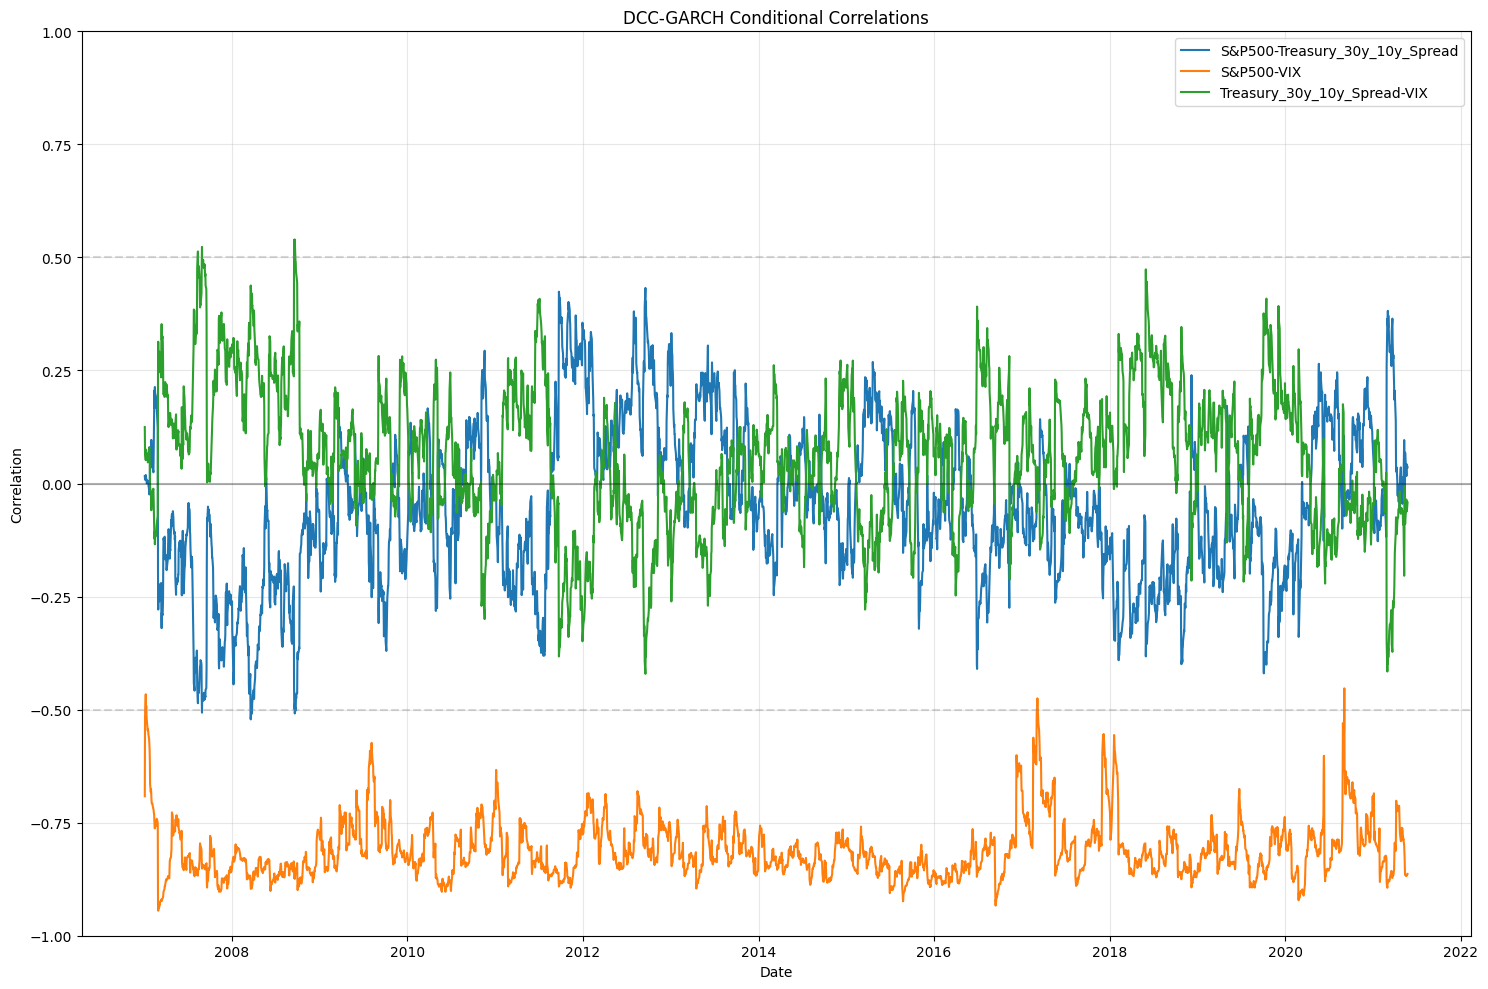

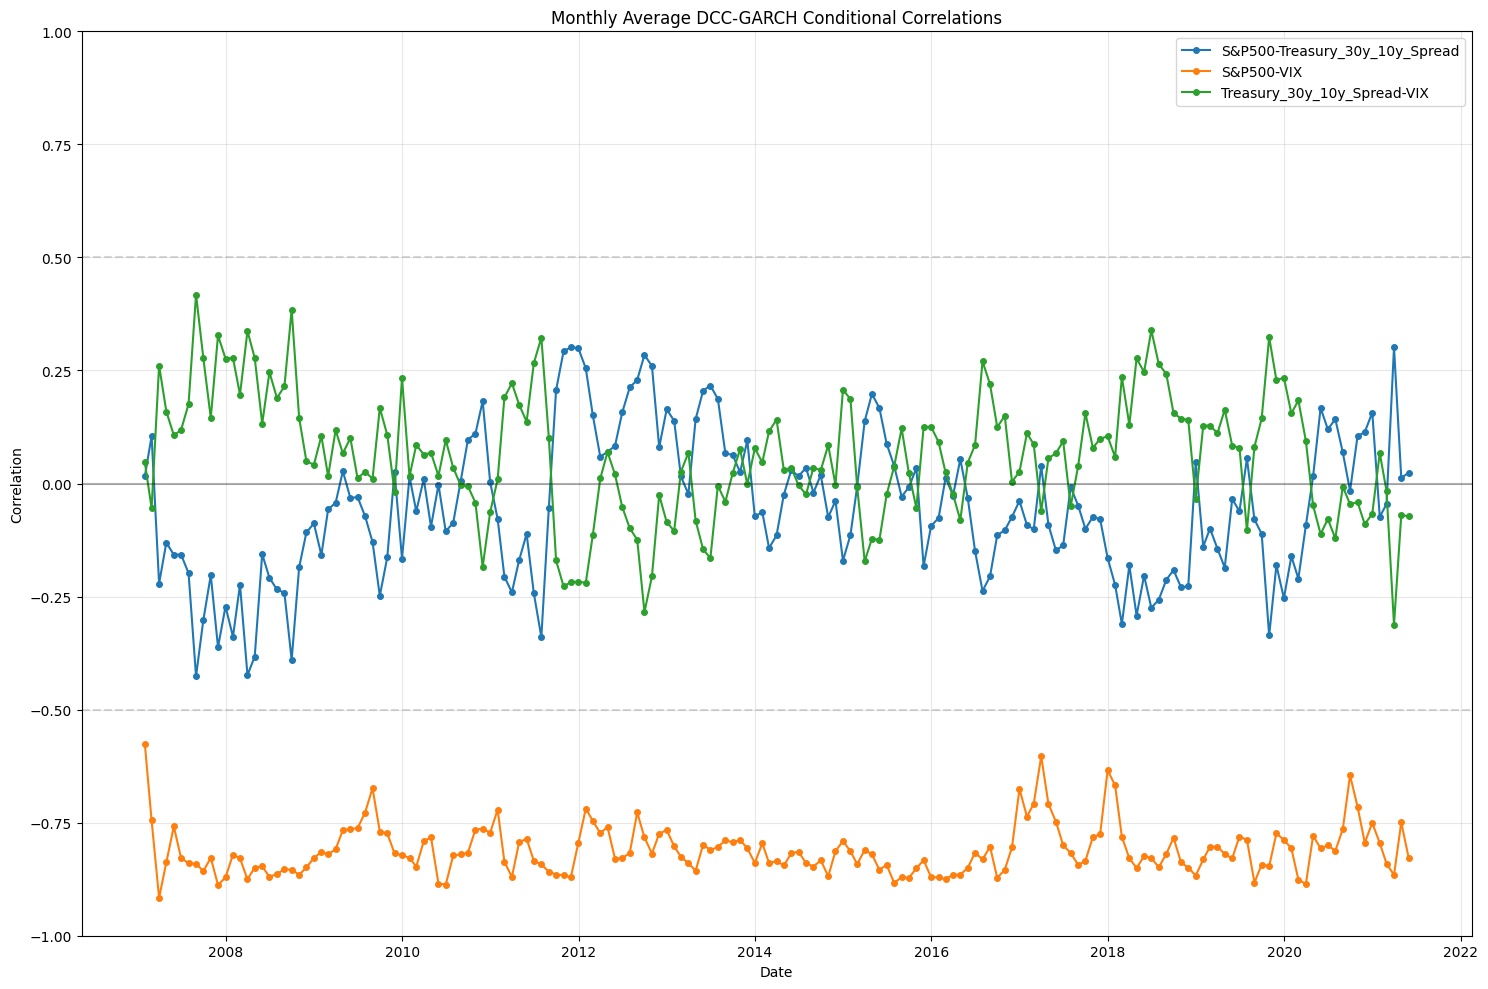

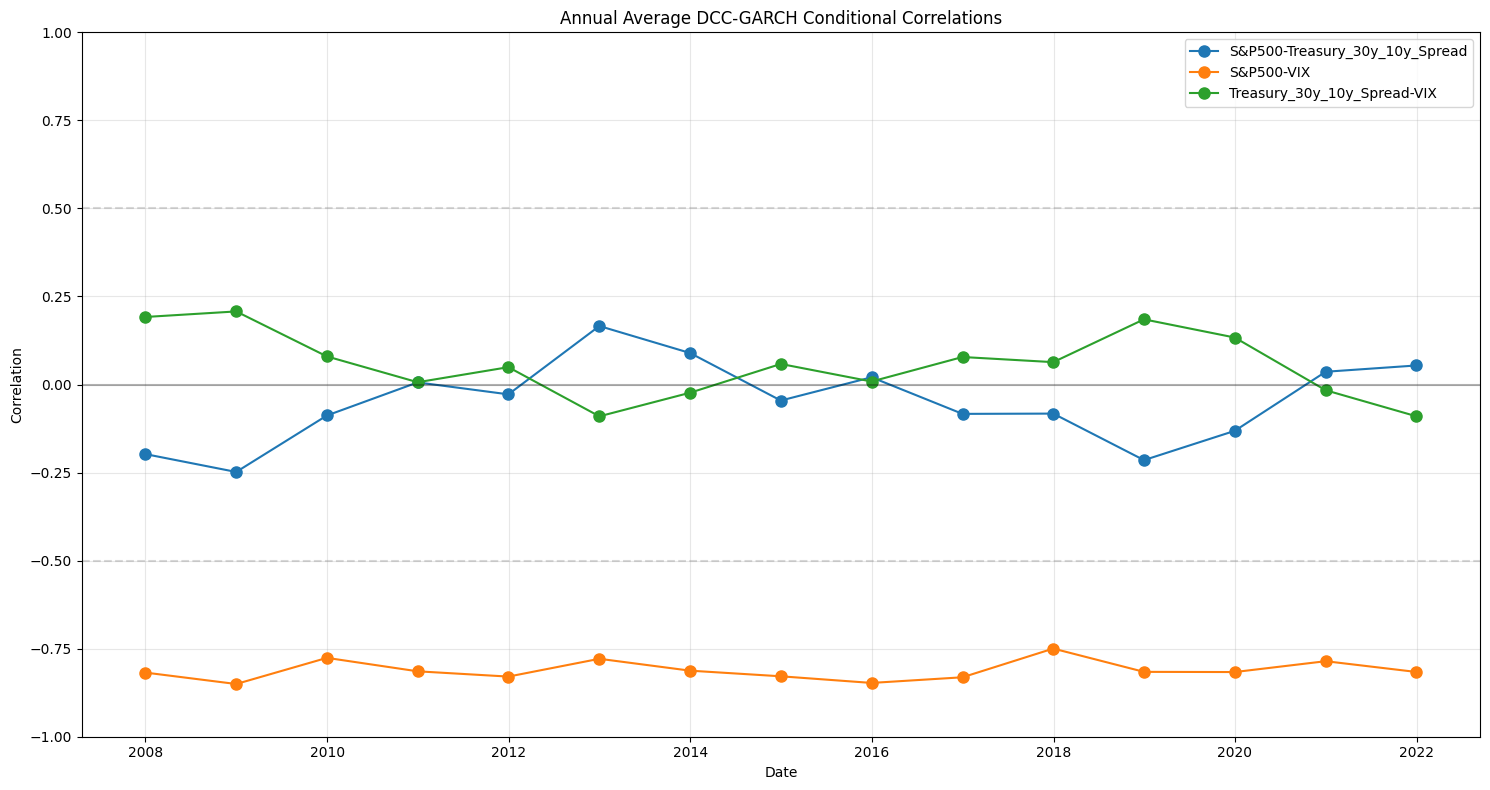

In [10]:
def plot_dcc_garch_correlations(correlations, dates, asset_names):
    """
    Plot conditional correlations from DCC-GARCH model for all pairs of assets
    
    Parameters:
    correlations: numpy array of shape (n_obs, n_assets, n_assets) containing correlation matrices
    dates: pandas DatetimeIndex with dates corresponding to observations
    asset_names: list of asset names corresponding to the assets
    
    Returns:
    pandas.DataFrame: DataFrame with all unique pairwise correlations
    """
    n_assets = len(asset_names)
    n_obs = correlations.shape[0]
    
    # Create empty DataFrame with dates as index
    df_corr = pd.DataFrame(index=dates)
    
    # Extract unique correlation pairs and add to DataFrame
    for i in range(n_assets):
        for j in range(i+1, n_assets):
            pair_name = f"{asset_names[i]}-{asset_names[j]}"
            # Get the correlation time series for this pair
            corr_series = correlations[:, i, j]
            # Make sure the length matches the dates
            if len(corr_series) == len(dates):
                df_corr[pair_name] = corr_series
            else:
                print(f"Warning: Length mismatch for {pair_name}. Expected {len(dates)}, got {len(corr_series)}")
    
    # Plot daily correlations
    plt.figure(figsize=(15, 10))
    for pair in df_corr.columns:
        plt.plot(df_corr.index, df_corr[pair], label=pair)
    
    plt.title('DCC-GARCH Conditional Correlations')
    plt.xlabel('Date')
    plt.ylabel('Correlation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(-1, 1)  # Correlation ranges from -1 to 1
    
    # Add horizontal lines at 0, 0.5, and -0.5 for reference
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)
    plt.axhline(y=-0.5, color='gray', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and plot monthly and annual average correlations
    monthly_corr = df_corr.resample('ME').mean()
    annual_corr = df_corr.resample('YE').mean()
    
    # Monthly correlations
    plt.figure(figsize=(15, 10))
    for pair in monthly_corr.columns:
        plt.plot(monthly_corr.index, monthly_corr[pair], label=pair, marker='o', markersize=4)
    
    plt.title('Monthly Average DCC-GARCH Conditional Correlations')
    plt.xlabel('Date')
    plt.ylabel('Correlation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(-1, 1)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)
    plt.axhline(y=-0.5, color='gray', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Annual correlations
    plt.figure(figsize=(15, 8))
    for pair in annual_corr.columns:
        plt.plot(annual_corr.index, annual_corr[pair], label=pair, marker='o', markersize=8)
    
    plt.title('Annual Average DCC-GARCH Conditional Correlations')
    plt.xlabel('Date')
    plt.ylabel('Correlation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(-1, 1)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)
    plt.axhline(y=-0.5, color='gray', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return df_corr

# Transpose correlations array to match expected shape (n_obs, n_assets, n_assets)
correlations_transposed = np.transpose(correlations, (2, 0, 1))

# Plot the correlations
df_corr = plot_dcc_garch_correlations(correlations_transposed, df_train.index, df_train.columns)

The plot shows how the correlations among the S&P 500, the 30y–10y Treasury yield spread, and the VIX have evolved over time under a DCC‑GARCH.

Correlation between S&P 500 and the 30y–10y Treasury spread

This measures how stock market returns move in tandem (or in opposition) with the difference between the 30‑year and 10‑year Treasury yields.
When this spread widens (i.e., a “steepening” long end of the yield curve), it can reflect expectations of higher long-term growth or inflation, which often coincides with positive stock market sentiment. In such times, we’ll often see a positive correlation.

At other points—especially if a flattening or inverting yield curve signals economic slowdown—stocks may sell off, driving a lower or even negative correlation.

The result is a correlation that hovers around zero to moderately positive but can swing in either direction depending on the market regime.

Correlation between the 30y–10y Treasury spread and the VIX

The VIX is a “fear gauge,” reflecting implied volatility in equity markets.
The 30y–10y spread is a gauge of the long-end slope of the yield curve.
The positive (but varying) correlation suggests that at times when the spread is increasing (perhaps due to shifting growth or inflation expectations), market uncertainty can also rise, pushing VIX higher.

However, this relationship can change if, for example, a steeper yield curve is seen as a sign of healthy growth (potentially reducing volatility) or if a flattening curve reflects looming risk (potentially raising volatility). That leads to the oscillations we see in the green line.

Correlation between S&P 500 and the VIX

This is typically strongly negative, reflecting the well-known inverse relationship between equity returns and implied volatility.
When stocks sell off, volatility tends to spike (negative correlation); when stocks rally, volatility usually drifts lower.

We can see the correlation dipping toward –0.7 or even –0.8 at times of market stress (e.g., financial crises, sharp corrections), consistent with this “fear response” in volatility when equity prices fall.
Overall, these lines highlight how each pair of variables moves together over time and how those relationships shift during different market conditions. The DCC‑GARCH model captures these changing correlations more flexibly than a single, fixed correlation estimate would.

## Regime Detection

/home/mj-hussain/MScFE/MScFE/10-Capstone Project/Code and Analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                         Markov Switching Model Results                        
Dep. Variable:                       y   No. Observations:                 3622
Model:                MarkovRegression   Log Likelihood               -5060.846
Date:              جمعه, 28 فروری 2025   AIC                          10133.693
Time:                         03:13:48   BIC                          10170.861
Sample:                              0   HQIC                         10146.935
                                - 3622                                         
Covariance Type:                approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0167      0.026    -38.500      0.000      -1.068      -0.965
sigma2         0.4700      0.020     23.658 

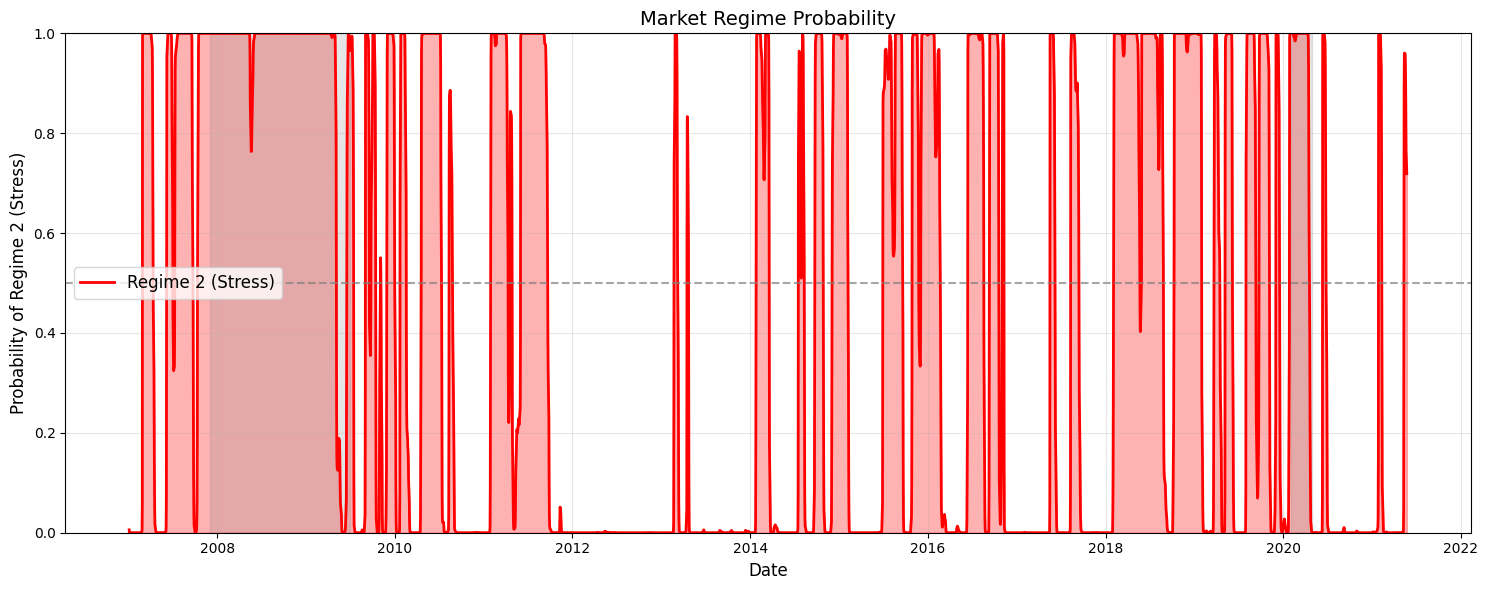

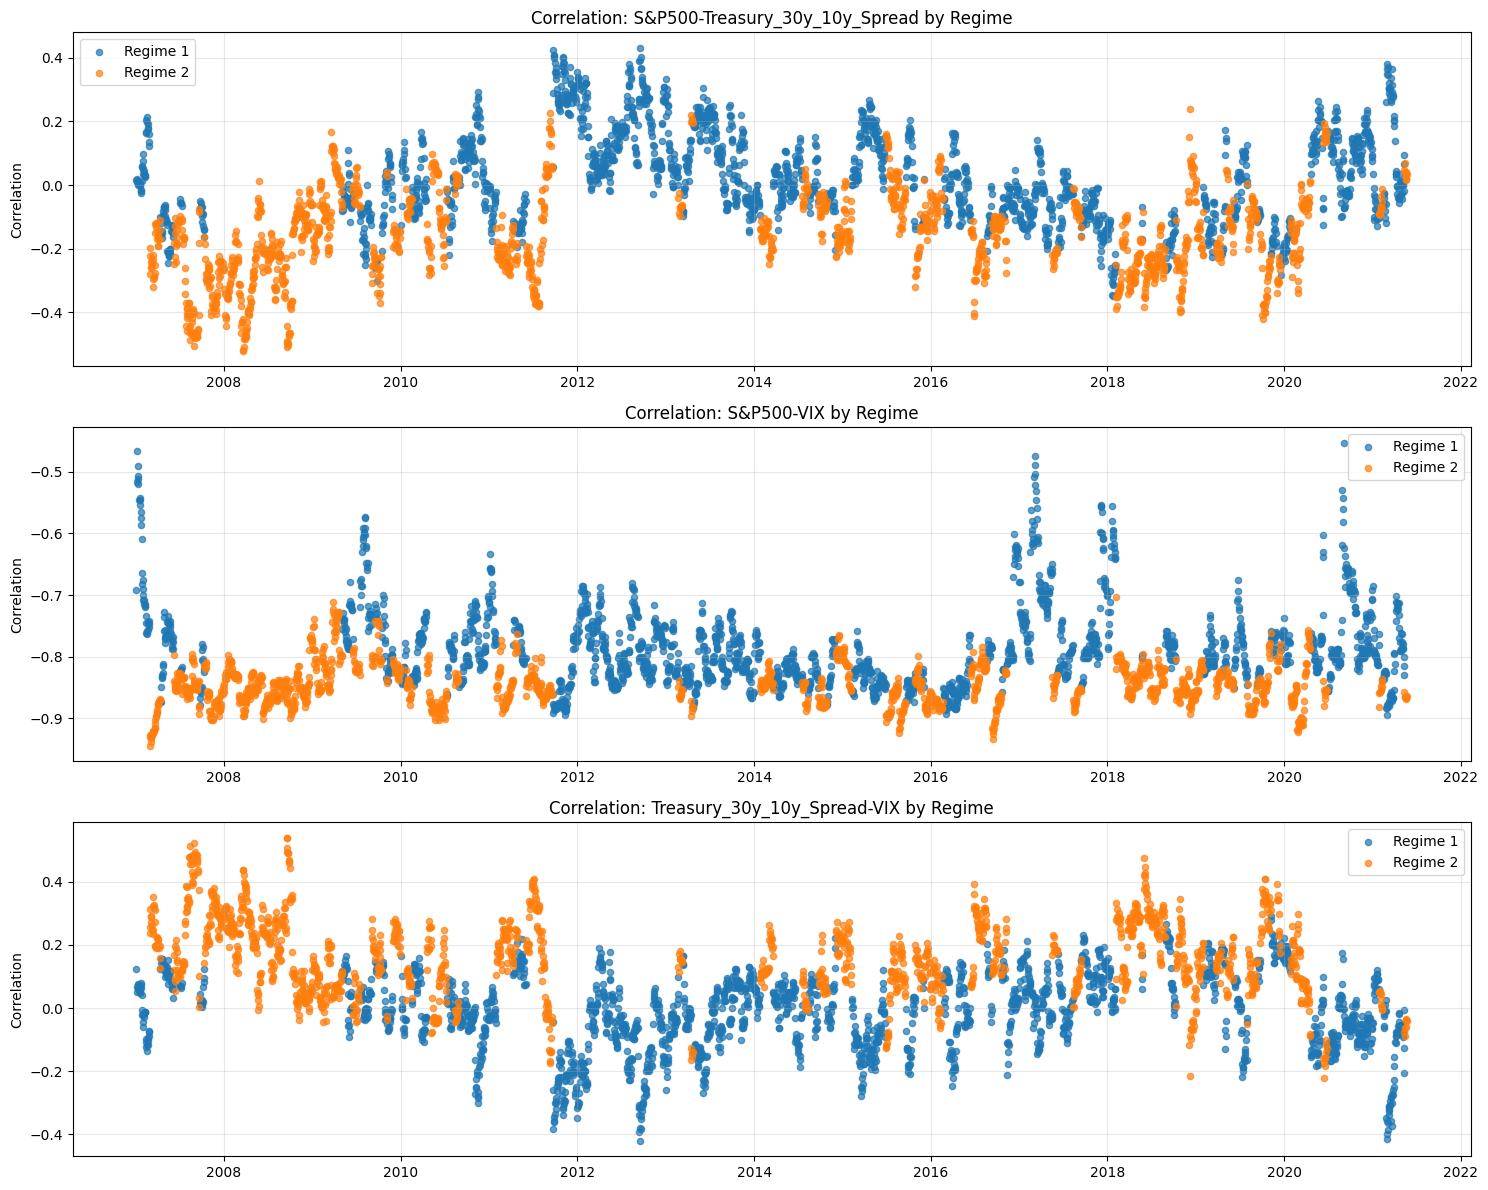

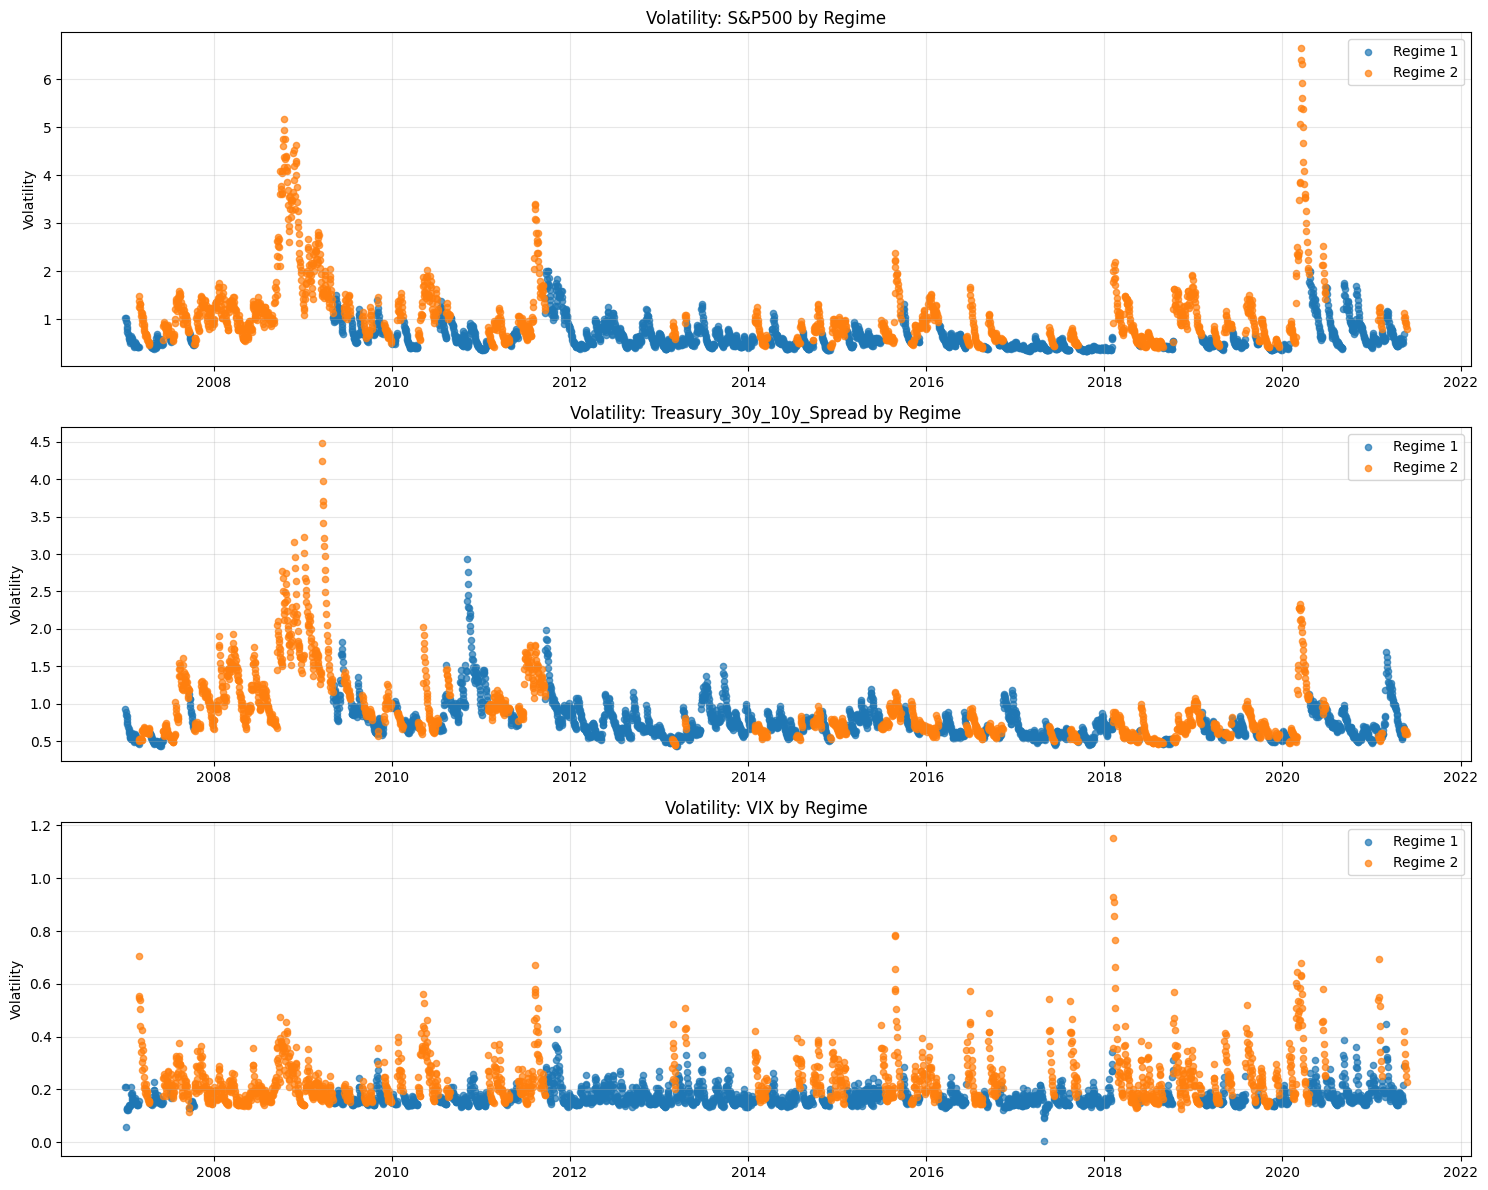


Regime Summary Statistics:
                      Regime 1   Regime 2
Avg Duration (days)  73.125000  56.575000
Frequency (%)        56.570955  43.429045

Average Correlations by Regime:
Regime 1:
S&P500-Treasury_30y_10y_Spread    0.034255
S&P500-VIX                       -0.783439
Treasury_30y_10y_Spread-VIX      -0.018298
dtype: float64

Regime 2:
S&P500-Treasury_30y_10y_Spread   -0.169406
S&P500-VIX                       -0.847198
Treasury_30y_10y_Spread-VIX       0.167423
dtype: float64


Average Volatilities by Regime:
Regime 1:
S&P500                     0.630827
Treasury_30y_10y_Spread    0.763565
VIX                        0.171359
dtype: float64

Regime 2:
S&P500                     1.194151
Treasury_30y_10y_Spread    0.973313
VIX                        0.244359
dtype: float64



In [ ]:
from sklearn.decomposition import PCA

def detect_market_regimes(df_corr, volatilities, asset_names, n_regimes=2):
    """
    Detect market regimes using a Markov switching model on correlation and volatility data.
    
    Parameters:
    df_corr (pd.DataFrame): DataFrame of conditional correlations
    volatilities (numpy.ndarray): Array of conditional volatilities
    asset_names (list): List of asset names
    n_regimes (int): Number of regimes to detect (default: 2)
    
    Returns:
    tuple: (regime probabilities, regime classifications, model)
    """
    import statsmodels.api as sm
    
    # Create features for the model
    # We'll use both correlations and volatilities
    features = pd.DataFrame(index=df_corr.index)
    
    # Add correlations
    for col in df_corr.columns:
        features[f'corr_{col}'] = df_corr[col]
    
    # Add volatilities 
    vol_df = pd.DataFrame(volatilities, index=df_corr.index, columns=asset_names)
    for col in vol_df.columns:
        features[f'vol_{col}'] = vol_df[col]
    
    # Standardize features for better regime detection
    features_std = (features - features.mean()) / features.std()
    
    # Fit Markov switching model to the first principal component of the features
    pca = PCA(n_components=1)
    pc1 = pca.fit_transform(features_std)
    pc1_series = pd.Series(pc1.flatten(), index=features.index)
    
    # Fit the Markov switching model
    mod = sm.tsa.MarkovRegression(pc1_series, k_regimes=n_regimes, trend='c', switching_variance=True)
    res = mod.fit()
    
    print(res.summary())
    
    # Get smoothed regime probabilities
    regime_probs = res.smoothed_marginal_probabilities
    regime_df = pd.DataFrame(regime_probs, index=features.index)
    
    # Classify each point into its most likely regime
    regime_classification = regime_df.idxmax(axis=1)
    
    # Plot the regime probabilities - improved to show only one regime (others implied)
    plt.figure(figsize=(15, 6))
    
    # Choose the most interesting regime to plot (typically regime 1 for stress periods)
    primary_regime = 1  # Usually regime 1 represents stress/crisis periods
    
    # Plot the main regime probability
    plt.plot(regime_df.index, regime_df[primary_regime], 
             color='red', linewidth=2, label=f'Regime {primary_regime+1} (Stress)')
    
    # Fill the area under the curve for visual emphasis
    plt.fill_between(regime_df.index, 0, regime_df[primary_regime], 
                     color='red', alpha=0.3)
    
    # Add horizontal reference line at 0.5 probability
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
    
    # Mark key recession periods if available
    try:
        for recession_period in recession_periods:
            plt.axvspan(recession_period[0], recession_period[1], 
                        color='gray', alpha=0.2)
    except:
        pass  # If recession_periods not defined, skip this
        
    plt.title('Market Regime Probability', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(f'Probability of Regime {primary_regime+1} (Stress)', fontsize=12)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Plot correlations by regime (unchanged)
    plt.figure(figsize=(15, 12))
    
    # Create a categorical variable for coloring
    regime_colors = {i: plt.cm.tab10(i) for i in range(n_regimes)}
    
    # Plot each correlation pair
    for i, col in enumerate(df_corr.columns):
        plt.subplot(len(df_corr.columns), 1, i+1)
        
        # Plot the correlation series
        for regime in range(n_regimes):
            regime_mask = (regime_classification == regime)
            plt.scatter(
                df_corr.index[regime_mask], 
                df_corr[col][regime_mask],
                color=regime_colors[regime],
                label=f'Regime {regime+1}',
                alpha=0.7,
                s=20
            )
            
        plt.title(f'Correlation: {col} by Regime')
        plt.ylabel('Correlation')
        plt.grid(True, alpha=0.3)
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot volatilities by regime 
    plt.figure(figsize=(15, 12))
    
    # Plot each asset's volatility
    for i, asset in enumerate(asset_names):
        plt.subplot(len(asset_names), 1, i+1)
        
        # Plot the volatility series
        for regime in range(n_regimes):
            regime_mask = (regime_classification == regime)
            plt.scatter(
                vol_df.index[regime_mask],
                vol_df[asset][regime_mask],
                color=regime_colors[regime], 
                label=f'Regime {regime+1}',
                alpha=0.7,
                s=20
            )
        
        plt.title(f'Volatility: {asset} by Regime')
        plt.ylabel('Volatility')
        plt.grid(True, alpha=0.3)
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Create a table summarizing the characteristics of each regime
    regime_summary = pd.DataFrame(index=['Avg Duration (days)', 'Frequency (%)'])
    
    # Add regime statistics
    for regime in range(n_regimes):
        # Calculate average duration
        regime_periods = (regime_classification == regime).astype(int)
        regime_changes = regime_periods.diff().abs()
        start_indices = regime_periods.index[regime_periods & (regime_changes == 1)]
        end_indices = regime_periods.index[(~regime_periods) & (regime_changes == 1)]
        
        if len(start_indices) > 0 and len(end_indices) > 0:
            if end_indices[0] < start_indices[0]:
                end_indices = end_indices[1:]
            if len(start_indices) > len(end_indices):
                start_indices = start_indices[:-1]
            
            durations = [(end - start).days for start, end in zip(start_indices, end_indices)]
            avg_duration = np.mean(durations) if durations else 0
        else:
            avg_duration = 0
            
        # Calculate frequency
        frequency = (regime_classification == regime).mean() * 100
        
        regime_summary[f'Regime {regime+1}'] = [avg_duration, frequency]
    
    print("\nRegime Summary Statistics:")
    print(regime_summary)
    
    # Calculate and display average correlations and volatilities per regime
    print("\nAverage Correlations by Regime:")
    for regime in range(n_regimes):
        regime_mask = (regime_classification == regime)
        regime_corr = df_corr[regime_mask].mean()
        print(f"Regime {regime+1}:")
        print(regime_corr)
        print()
    
    print("\nAverage Volatilities by Regime:")
    for regime in range(n_regimes):
        regime_mask = (regime_classification == regime)
        regime_vol = vol_df[regime_mask].mean()
        print(f"Regime {regime+1}:")
        print(regime_vol)
        print()
    
    return regime_df, regime_classification, res

# Call the function with the correlation data and volatilities
regime_probs, regime_states, model = detect_market_regimes(df_corr, volatilities, df_train.columns)

The Markov Switching model has identified two distinct market regimes. Let's break down what these results.

The Two Market Regimes

Regime 0: Lower Volatility/Normal Market Conditions

Mean value (const): -1.0167

Volatility (sigma2): 0.4700 (significantly lower volatility)

This appears to be "normal" or "calm" market state

Regime 1: Higher Volatility/Stressed Market Conditions

Mean value (const): 1.3325

Volatility (sigma2): 1.7547 (about 3.7 times higher volatility than Regime 0)

This represents "stressed" or "crisis" market state

Regime Transition Dynamics

Persistence of Regime 0

p[0->0] = 0.9798: Once the market enters the calm state (Regime 0), it tends to stay there with a very high probability (98%) on any given day.
This implies an expected duration of 1/(1-0.9798) = 49.5 days for Regime 0

Persistence of Regime 1
p[1->0] = 0.0265: The probability of switching from the stressed state (Regime 1) back to the calm state is only about 2.65% on any given day

By extension, p[1->1] = 0.9735 (staying in Regime 1)
This implies an expected duration of 1/0.0265 = 37.7 days for Regime 1

Statistical Significance

All parameters are highly statistically significant (P>|z| values are 0.000), indicating strong confidence in the regime identification.


Financial Interpretation

Well-defined regimes: The model has identified two clearly distinct market states with different means and volatilities.

Asymmetric transitions: Transitions from calm to stressed states are much less likely than remaining in the current state. This aligns with financial market behavior where crises tend to develop relatively quickly but persist for extended periods.

Crisis characteristics: Regime 1 shows both higher mean and significantly higher variance, suggesting it captures periods of market stress or crisis.

Regime persistence: Both regimes show strong persistence (high probability of staying in the same regime), reflecting the tendency of financial markets to maintain their current condition rather than frequently switching between states.
